<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Lab 5: Transfer Learning for Image Classification
</div>


Welcome to this tutorial! Here, we'll explore the process of training a Convolutional Neural Network (CNN) for image classification through the powerful technique of transfer learning. To gain a deeper understanding of transfer learning, consider reviewing the comprehensive [cs231n notes](https://cs231n.github.io/transfer-learning/).

#### The Essence of Transfer Learning

A common challenge in training CNNs is the requirement for a large and diverse dataset. However, not every project or task has the luxury of such a dataset. This is where transfer learning becomes invaluable. In transfer learning, we leverage a pre-trained model— a model trained on a vast dataset, like ImageNet—and adapt it for a different, often more specific task.

#### Key Transfer Learning Scenarios

There are two primary approaches to using a pre-trained model in transfer learning:

1. **Finetuning the ConvNet:**
   - **Process:** Start with a pre-trained model and fine-tune it for a specific task.
   - **Initialization:** We initialize the model with the weights of a pre-trained network, ensuring a strong and relevant foundation.
   - **Training:** The model is then trained further on the new, specific dataset. It adapts and refines the pre-existing knowledge to fit the new data and task at hand.

2. **ConvNet as Fixed Feature Extractor:**
   - **Process:** Use the pre-trained model as a feature extractor and only train a new classifier on top of it.
   - **Frozen Layers:** All the layers of the pre-trained model, except the final fully connected layer, are frozen. Their weights remain unchanged.
   - **New Layer:** The final layer is replaced with a new one, initialized with random weights. This layer is then trained on the new dataset.
   - **Result:** The model harnesses the features learned from the large dataset and combines them with the specific learnings from the new data.

### Download training dataset

In [4]:
# # Download dataset
# !wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
# !wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy


--2023-11-04 19:16:22--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M) [application/octet-stream]
Saving to: ‘normal.npy’

100%[======================================>] 65,536,128  11.0MB/s   in 6.5s   

2023-11-04 19:16:31 (9.64 MB/s) - ‘normal.npy’ saved [65536128/65536128]

--2023-11-04 19:16:31--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

### Import module

In [174]:
import torch
from torch.utils.data import DataLoader, TensorDataset
# from torch.utils.data import random_split
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights
from torchvision.models import EfficientNet_B0_Weights
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os

In [80]:
# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [188]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. No GPU found.")


GPU 0: NVIDIA RTX A6000
GPU 1: NVIDIA RTX A6000


In [12]:
torch.cuda.is_available()

True

In [6]:
# Set a seed for Numpy's random number generator
np.random.seed(42)  # You can use any number as the seed

# Set a seed for PyTorch's random number generator for all devices (both CPU and CUDA)
torch.manual_seed(42)

# # If you are using multi-GPU, you should also set:
# torch.cuda.manual_seed_all(42)

# # Additional steps to increase reproducibility
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False


## A. Data Loading and Preprocessing

Use PyTorch  [`Tensor.repeat()`](https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html) to change the number of channels from 1 to 3.


In [9]:
# Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

# Perform shuffling in-place
np.random.shuffle(abnormal_scans)
np.random.shuffle(normal_scans)

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float().unsqueeze(1).repeat(1, 3, 1, 1)
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float().unsqueeze(1).repeat(1, 3, 1, 1)
y_val = torch.from_numpy(y_val).long()


Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)


In [10]:
# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')


Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


## B. Defining Neural Networks

### 1. Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.

### 2. ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

In [9]:

model = models.resnet18(weights='IMAGENET1K_V1')

# ConvNet as fixed feature extractor (freeze parameters)
# for param in model.parameters():
#     param.requires_grad = False
    
num_ftrs = model.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## C. Training the Neural Network

In [10]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs =30

# Change you model here
# model = ConvGAP()
# print(model)
# model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()
            
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  3%|█▎                                       | 1/30 [00:02<01:19,  2.74s/it]

Epoch 1/30, Train loss: 0.2100, Train acc: 91.81%, Val loss: 0.1356, Val acc: 95.00%, Best Val loss: 0.1356 Best Val acc: 95.00%


  7%|██▋                                      | 2/30 [00:04<01:03,  2.26s/it]

Epoch 2/30, Train loss: 0.0742, Train acc: 97.56%, Val loss: 0.0654, Val acc: 97.75%, Best Val loss: 0.0654 Best Val acc: 97.75%


 10%|████                                     | 3/30 [00:06<00:56,  2.08s/it]

Epoch 3/30, Train loss: 0.0520, Train acc: 98.19%, Val loss: 0.1244, Val acc: 95.50%, Best Val loss: 0.0654 Best Val acc: 97.75%


 13%|█████▍                                   | 4/30 [00:08<00:52,  2.00s/it]

Epoch 4/30, Train loss: 0.0715, Train acc: 97.31%, Val loss: 1.0956, Val acc: 58.00%, Best Val loss: 0.0654 Best Val acc: 97.75%


 17%|██████▊                                  | 5/30 [00:10<00:48,  1.96s/it]

Epoch 5/30, Train loss: 0.0403, Train acc: 98.00%, Val loss: 0.0622, Val acc: 97.25%, Best Val loss: 0.0622 Best Val acc: 97.75%


 20%|████████▏                                | 6/30 [00:12<00:46,  1.94s/it]

Epoch 6/30, Train loss: 0.0378, Train acc: 98.50%, Val loss: 0.0274, Val acc: 99.25%, Best Val loss: 0.0274 Best Val acc: 99.25%


 23%|█████████▌                               | 7/30 [00:14<00:44,  1.92s/it]

Epoch 7/30, Train loss: 0.0159, Train acc: 99.62%, Val loss: 0.0506, Val acc: 98.25%, Best Val loss: 0.0274 Best Val acc: 99.25%


 27%|██████████▉                              | 8/30 [00:15<00:41,  1.91s/it]

Epoch 8/30, Train loss: 0.0197, Train acc: 99.38%, Val loss: 0.0319, Val acc: 98.25%, Best Val loss: 0.0274 Best Val acc: 99.25%


 30%|████████████▎                            | 9/30 [00:17<00:39,  1.90s/it]

Epoch 9/30, Train loss: 0.0123, Train acc: 99.56%, Val loss: 0.0373, Val acc: 98.25%, Best Val loss: 0.0274 Best Val acc: 99.25%


 33%|█████████████▎                          | 10/30 [00:19<00:37,  1.89s/it]

Epoch 10/30, Train loss: 0.0055, Train acc: 99.94%, Val loss: 0.0541, Val acc: 97.50%, Best Val loss: 0.0274 Best Val acc: 99.25%


 37%|██████████████▋                         | 11/30 [00:21<00:35,  1.89s/it]

Epoch 11/30, Train loss: 0.0078, Train acc: 99.62%, Val loss: 0.0335, Val acc: 98.75%, Best Val loss: 0.0274 Best Val acc: 99.25%


 40%|████████████████                        | 12/30 [00:23<00:33,  1.88s/it]

Epoch 12/30, Train loss: 0.0033, Train acc: 99.88%, Val loss: 0.0341, Val acc: 98.25%, Best Val loss: 0.0274 Best Val acc: 99.25%


 43%|█████████████████▎                      | 13/30 [00:25<00:31,  1.88s/it]

Epoch 13/30, Train loss: 0.0135, Train acc: 99.50%, Val loss: 0.3699, Val acc: 93.25%, Best Val loss: 0.0274 Best Val acc: 99.25%


 47%|██████████████████▋                     | 14/30 [00:27<00:30,  1.88s/it]

Epoch 14/30, Train loss: 0.0435, Train acc: 98.50%, Val loss: 0.1821, Val acc: 95.75%, Best Val loss: 0.0274 Best Val acc: 99.25%


 50%|████████████████████                    | 15/30 [00:29<00:28,  1.88s/it]

Epoch 15/30, Train loss: 0.0305, Train acc: 98.94%, Val loss: 0.0523, Val acc: 97.75%, Best Val loss: 0.0274 Best Val acc: 99.25%


 53%|█████████████████████▎                  | 16/30 [00:30<00:26,  1.88s/it]

Epoch 16/30, Train loss: 0.0092, Train acc: 99.69%, Val loss: 0.0834, Val acc: 97.25%, Best Val loss: 0.0274 Best Val acc: 99.25%


 57%|██████████████████████▋                 | 17/30 [00:32<00:24,  1.88s/it]

Epoch 17/30, Train loss: 0.0228, Train acc: 99.25%, Val loss: 0.0546, Val acc: 98.00%, Best Val loss: 0.0274 Best Val acc: 99.25%


 60%|████████████████████████                | 18/30 [00:34<00:22,  1.88s/it]

Epoch 18/30, Train loss: 0.0033, Train acc: 100.00%, Val loss: 0.0193, Val acc: 99.25%, Best Val loss: 0.0193 Best Val acc: 99.25%


 63%|█████████████████████████▎              | 19/30 [00:36<00:20,  1.89s/it]

Epoch 19/30, Train loss: 0.0009, Train acc: 100.00%, Val loss: 0.0129, Val acc: 99.75%, Best Val loss: 0.0129 Best Val acc: 99.75%


 67%|██████████████████████████▋             | 20/30 [00:38<00:18,  1.89s/it]

Epoch 20/30, Train loss: 0.0021, Train acc: 99.88%, Val loss: 0.0508, Val acc: 97.50%, Best Val loss: 0.0129 Best Val acc: 99.75%


 70%|████████████████████████████            | 21/30 [00:40<00:16,  1.89s/it]

Epoch 21/30, Train loss: 0.0047, Train acc: 99.88%, Val loss: 0.0183, Val acc: 99.25%, Best Val loss: 0.0129 Best Val acc: 99.75%


 73%|█████████████████████████████▎          | 22/30 [00:42<00:15,  1.89s/it]

Epoch 22/30, Train loss: 0.0105, Train acc: 99.62%, Val loss: 0.0693, Val acc: 97.50%, Best Val loss: 0.0129 Best Val acc: 99.75%


 77%|██████████████████████████████▋         | 23/30 [00:44<00:13,  1.88s/it]

Epoch 23/30, Train loss: 0.0028, Train acc: 99.88%, Val loss: 0.0758, Val acc: 97.00%, Best Val loss: 0.0129 Best Val acc: 99.75%


 80%|████████████████████████████████        | 24/30 [00:46<00:11,  1.88s/it]

Epoch 24/30, Train loss: 0.0010, Train acc: 100.00%, Val loss: 0.0390, Val acc: 98.50%, Best Val loss: 0.0129 Best Val acc: 99.75%


 83%|█████████████████████████████████▎      | 25/30 [00:47<00:09,  1.89s/it]

Epoch 25/30, Train loss: 0.0002, Train acc: 100.00%, Val loss: 0.0245, Val acc: 99.00%, Best Val loss: 0.0129 Best Val acc: 99.75%


 87%|██████████████████████████████████▋     | 26/30 [00:49<00:07,  1.89s/it]

Epoch 26/30, Train loss: 0.0001, Train acc: 100.00%, Val loss: 0.0245, Val acc: 99.00%, Best Val loss: 0.0129 Best Val acc: 99.75%


 90%|████████████████████████████████████    | 27/30 [00:51<00:05,  1.89s/it]

Epoch 27/30, Train loss: 0.0001, Train acc: 100.00%, Val loss: 0.0296, Val acc: 99.25%, Best Val loss: 0.0129 Best Val acc: 99.75%


 93%|█████████████████████████████████████▎  | 28/30 [00:53<00:03,  1.89s/it]

Epoch 28/30, Train loss: 0.0001, Train acc: 100.00%, Val loss: 0.0251, Val acc: 99.25%, Best Val loss: 0.0129 Best Val acc: 99.75%


 97%|██████████████████████████████████████▋ | 29/30 [00:55<00:01,  1.89s/it]

Epoch 29/30, Train loss: 0.0000, Train acc: 100.00%, Val loss: 0.0254, Val acc: 99.25%, Best Val loss: 0.0129 Best Val acc: 99.75%


100%|████████████████████████████████████████| 30/30 [00:57<00:00,  1.91s/it]

Epoch 30/30, Train loss: 0.0000, Train acc: 100.00%, Val loss: 0.0245, Val acc: 99.25%, Best Val loss: 0.0129 Best Val acc: 99.75%


### Visualizing model performance

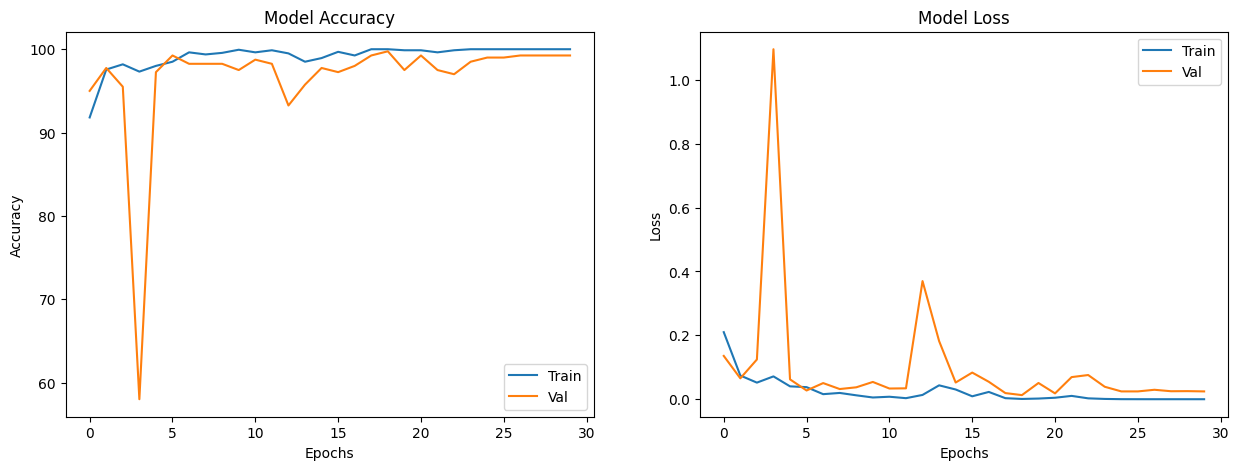

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [7]:
# !wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
# !wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy

### Process Test Dataset

In [8]:
test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_test = torch.from_numpy(x_test).float().unsqueeze(1).repeat(1, 3, 1, 1)
y_test = torch.from_numpy(y_test).long()

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)


In [9]:
# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, 32, shuffle=False)

### Load Trained Model and Evaluate

In [10]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        
        images = images.cuda()
        images = images / 255.
        
        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)
        
        predicted = outputs.argmax(-1)        
        test_correct += (predicted.float() == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

Test accuracy is 76.0%


### function get_dataset

In [32]:
def get_datasets():
    if not os.path.exists('normal.npy') or not os.path.exists('pneumonia.npy'):
        !wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
        !wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
    
    if not os.path.exists('test_normal.npy') or not os.path.exists('test_pneumonia.npy'):
        !wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
        !wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy
    
    np.random.seed(42)
    
    # Load Dataset
    abnormal_scans = np.load('pneumonia.npy')
    normal_scans = np.load('normal.npy')

    # Perform shuffling in-place
    np.random.shuffle(abnormal_scans)
    np.random.shuffle(normal_scans)

    print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
    print(f'Shape of normal_scans: {normal_scans.shape}')

    # For the data having presence of pneumonia assign 1, for the normal ones assign 0.

    abnormal_labels = np.ones((abnormal_scans.shape[0],))
    normal_labels = np.zeros((normal_scans.shape[0],))

    split_point = 800

    x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
    y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
    x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
    y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

    # Convert to PyTorch tensors
    x_train = torch.from_numpy(x_train).float().unsqueeze(1).repeat(1, 3, 1, 1)
    y_train = torch.from_numpy(y_train).long()
    x_val = torch.from_numpy(x_val).float().unsqueeze(1).repeat(1, 3, 1, 1)
    y_val = torch.from_numpy(y_val).long()

    # Create datasets
    train_dataset = TensorDataset(x_train, y_train)
    val_dataset = TensorDataset(x_val, y_val)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
    print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

    # test dataset
    test_abnormal = np.load('test_pneumonia.npy')
    test_normal = np.load('test_normal.npy')

    print(f'Shape of test_abnormal: {test_abnormal.shape}')
    print(f'Shape of test_normal: {test_normal.shape}')

    # For the data having presence of pneumonia assign 1, for the normal ones assign 0.
    test_abnormal_labels = np.ones((test_abnormal.shape[0],))
    test_normal_labels = np.zeros((test_normal.shape[0],))

    x_test = np.concatenate((test_abnormal, test_normal), axis=0)
    y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

    print(f'Shape of x_test: {x_test.shape}')
    print(f'Shape of y_test: {y_test.shape}')

    # Convert to PyTorch tensors
    x_test = torch.from_numpy(x_test).float().unsqueeze(1).repeat(1, 3, 1, 1)
    y_test = torch.from_numpy(y_test).long()
    
    # Combine the images and labels into a dataset
    test_dataset = TensorDataset(x_test, y_test)

    # Create a dataloader to load data in batches. Set batch size to 32.
    test_loader = DataLoader(test_dataset, 32, shuffle=False)
    
    return train_loader, val_loader, test_loader


### Fine turning ResNet50

In [55]:

# # Load the pre-trained ResNet50 model with the default weights
# model_resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# # # Load the pre-trained ResNet50 model
# # model = models.resnet50(pretrained=True)

# # Modify the final fully connected layer to match our binary classification task
# num_features = model_resnet50.fc.in_features  # the number of input features of the final fully connected layer
# model_resnet50.fc = nn.Linear(num_features, 2)  # override the final fc layer -- 2 classes: normal and pneumonia
# # model_resnet50 = override_fc(model_resnet50)


# # get datasets
# train_loader, val_loader, test_loader = get_datasets()

# # Move to the device selected
# model_resnet50 = model_resnet50.to(device)

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)


In [117]:
def get_model(model_name, fixed_feature=False):
    
    if model_name == 'ResNet50':
        model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        if fixed_feature:
            # Freeze all layers in the network
            for param in model.parameters():
                param.requires_grad = False
        # Modify the final fully connected layer to match our binary classification task
        num_features = model.fc.in_features  # the number of input features of the final fully connected layer
        model.fc = nn.Linear(num_features, 2)  # override the final fc layer -- 2 classes: normal and pneumonia
    
    elif model_name == 'EfficientNet-B0':
        model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        if fixed_feature:
            # Freeze all layers in the network
            for param in model.parameters():
                param.requires_grad = False
        # Replace the classifier with a new one with 2 outputs
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = torch.nn.Linear(num_ftrs, 2)
        
    else:
        print('No model is loaded.')
        return
    
    # Move to the device selected
    model = model.to(device)
    
    return model

In [168]:
def plot_accu_and_loss(train_accuracies, val_accuracies, train_losses, val_losses, 
                       file_name=None, ylim=(0.86, 1.02)):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Plotting training and validation accuracy
    ax[0].plot(train_accuracies)
    ax[0].plot(val_accuracies)
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(['Train', 'Val'])
    
    # Set x-axis major locator to integer values
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Set y-axis limits for the first subplot
    ax[0].set_ylim(*ylim)

    # Plotting training and validation loss
    ax[1].plot(train_losses)
    ax[1].plot(val_losses)
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend(['Train', 'Val'])
    
    # Set x-axis major locator to integer values
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    if file_name:
        plt.savefig(f'./assets/images/accs_and_losses_{file_name}.png')
    
    plt.show()

In [190]:

def train_model(model, train_loader=train_loader, val_loader=val_loader, num_epochs=15):
    # Initialize lists to keep track of loss and accuracy for each epoch
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    
    # hyperparameters
    # Define the loss function and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Optionally, define a learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # track history only if in train phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train' and scheduler:
                scheduler.step()
            
            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            # Collect the loss and accuracy for plotting
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)
            
            print(f'{phase} - Epoch {epoch}/{num_epochs - 1} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}')

    train_accs_cpu = [acc.cpu() for acc in train_accs]
    val_accs_cpu = [acc.cpu() for acc in val_accs]

    
    plot_accu_and_loss(train_accs_cpu, val_accs_cpu, train_losses, val_losses, file_name=None)

    return model, train_accs_cpu, val_accs_cpu, train_losses, val_losses


train - Epoch 0/19 - Loss: 0.2405 - Acc: 0.9094
val - Epoch 0/19 - Loss: 0.6715 - Acc: 0.9125
train - Epoch 1/19 - Loss: 0.1392 - Acc: 0.9519
val - Epoch 1/19 - Loss: 1.1738 - Acc: 0.5675
train - Epoch 2/19 - Loss: 0.0776 - Acc: 0.9700
val - Epoch 2/19 - Loss: 0.1905 - Acc: 0.9275
train - Epoch 3/19 - Loss: 0.0569 - Acc: 0.9775
val - Epoch 3/19 - Loss: 0.1433 - Acc: 0.9575
train - Epoch 4/19 - Loss: 0.0852 - Acc: 0.9681
val - Epoch 4/19 - Loss: 0.0832 - Acc: 0.9650
train - Epoch 5/19 - Loss: 0.0842 - Acc: 0.9738
val - Epoch 5/19 - Loss: 0.1065 - Acc: 0.9550
train - Epoch 6/19 - Loss: 0.0484 - Acc: 0.9825
val - Epoch 6/19 - Loss: 0.1878 - Acc: 0.9425
train - Epoch 7/19 - Loss: 0.0124 - Acc: 0.9975
val - Epoch 7/19 - Loss: 0.0580 - Acc: 0.9800
train - Epoch 8/19 - Loss: 0.0137 - Acc: 0.9962
val - Epoch 8/19 - Loss: 0.0585 - Acc: 0.9825
train - Epoch 9/19 - Loss: 0.0052 - Acc: 0.9994
val - Epoch 9/19 - Loss: 0.0405 - Acc: 0.9875
train - Epoch 10/19 - Loss: 0.0039 - Acc: 1.0000
val - Epoch

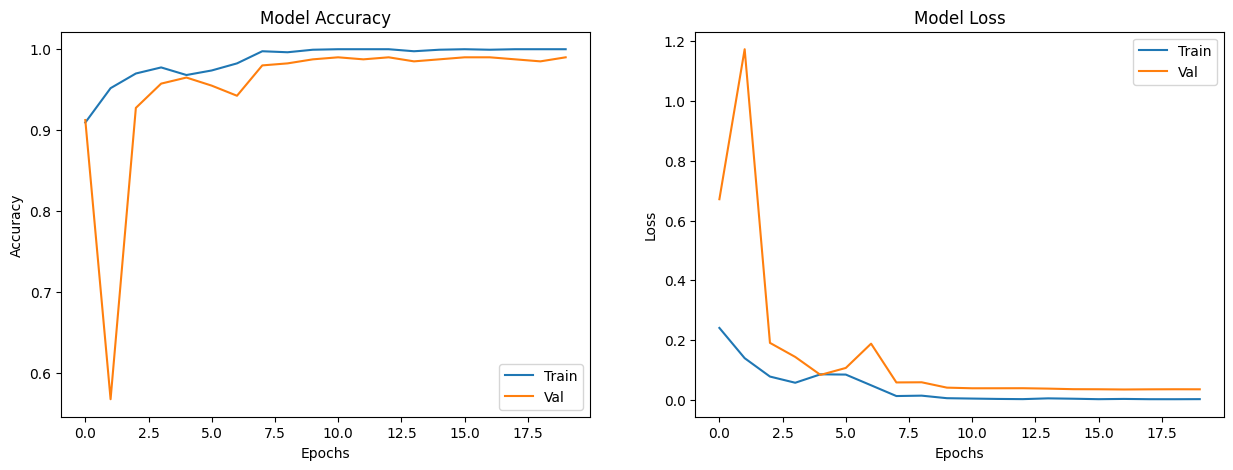

In [82]:
# Call the train_model function to train the network
model_resnet50_ft, *performance_resnet50_ft = train_model(model_resnet50, num_epochs=20)

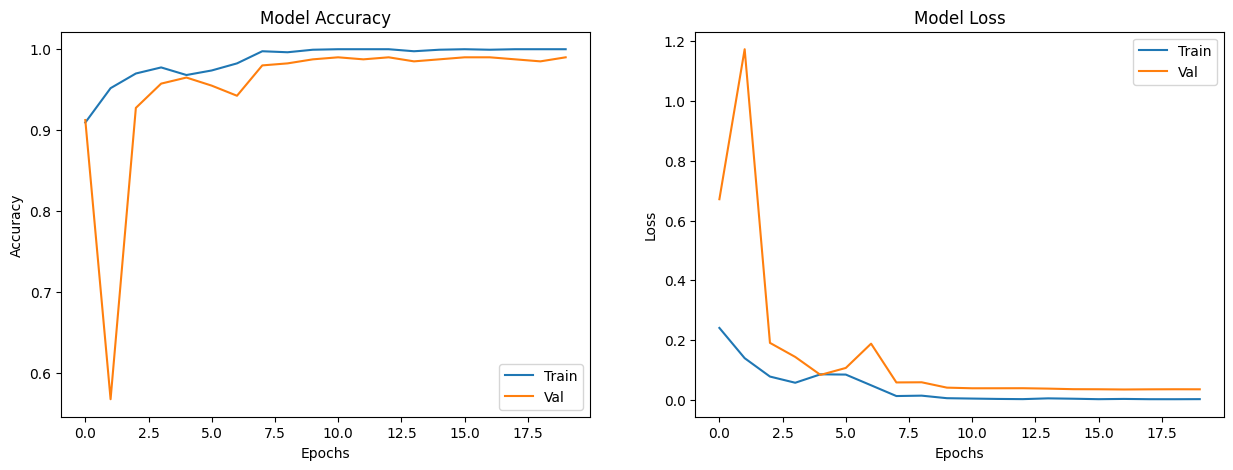

In [96]:
plot_accu_and_loss(*performance_resnet50_ft, file_name='resnet50_ft')

In [84]:
def calculate_test_accuracy(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [85]:
# Calculate the test accuracy
test_accuracy_resnet50_ft = calculate_test_accuracy(model_resnet50_ft, test_loader, device)
print(f'Test Accuracy: {test_accuracy_resnet50_ft * 100:.2f}%')

Test Accuracy: 78.00%


### Fine tuning EfficientNet

In [86]:
# Load the pre-trained EfficientNet B0 model with the default weights
weights = EfficientNet_B0_Weights.DEFAULT
model_efficientnet_b0 = models.efficientnet_b0(weights=weights)

# If you need to modify the classifier for a different number of output classes, for example:
num_classes = 2  # replace with the number of classes you need
model_efficientnet_b0.classifier[1] = torch.nn.Linear(model_efficientnet_b0.classifier[1].in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_efficientnet_b0.to(device)

# Print the model to verify changes (optional)
print(model_efficientnet_b0)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

train - Epoch 0/19 - Loss: 0.1840 - Acc: 0.9269
val - Epoch 0/19 - Loss: 0.0934 - Acc: 0.9650
train - Epoch 1/19 - Loss: 0.0796 - Acc: 0.9763
val - Epoch 1/19 - Loss: 0.0237 - Acc: 0.9925
train - Epoch 2/19 - Loss: 0.0426 - Acc: 0.9838
val - Epoch 2/19 - Loss: 0.0969 - Acc: 0.9550
train - Epoch 3/19 - Loss: 0.0486 - Acc: 0.9819
val - Epoch 3/19 - Loss: 0.0994 - Acc: 0.9600
train - Epoch 4/19 - Loss: 0.0341 - Acc: 0.9869
val - Epoch 4/19 - Loss: 0.0313 - Acc: 0.9875
train - Epoch 5/19 - Loss: 0.0352 - Acc: 0.9906
val - Epoch 5/19 - Loss: 0.0351 - Acc: 0.9875
train - Epoch 6/19 - Loss: 0.0084 - Acc: 0.9981
val - Epoch 6/19 - Loss: 0.0074 - Acc: 0.9975
train - Epoch 7/19 - Loss: 0.0068 - Acc: 0.9988
val - Epoch 7/19 - Loss: 0.0135 - Acc: 0.9900
train - Epoch 8/19 - Loss: 0.0019 - Acc: 0.9994
val - Epoch 8/19 - Loss: 0.0150 - Acc: 0.9900
train - Epoch 9/19 - Loss: 0.0020 - Acc: 1.0000
val - Epoch 9/19 - Loss: 0.0106 - Acc: 0.9975
train - Epoch 10/19 - Loss: 0.0048 - Acc: 0.9988
val - Epoch

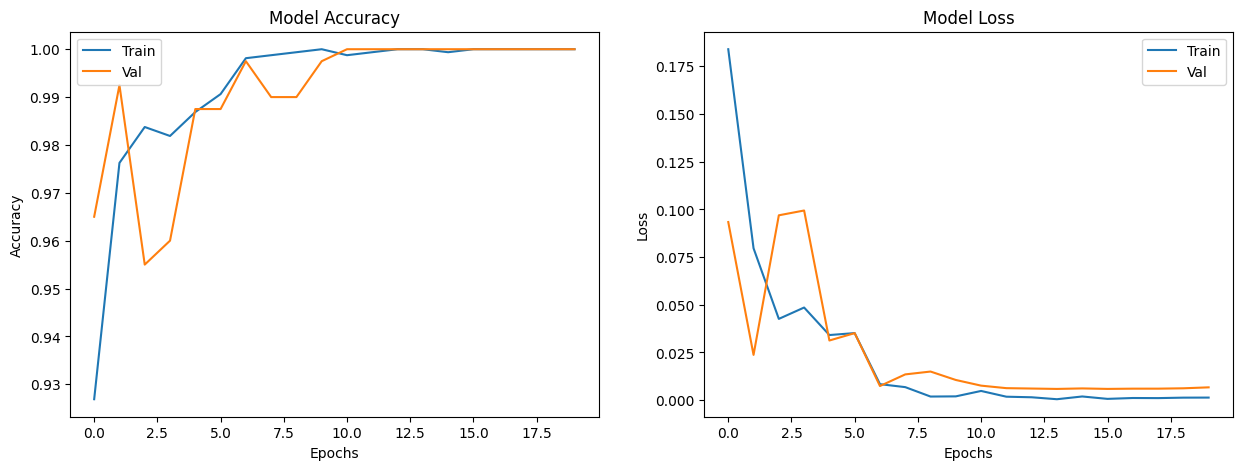

In [87]:
# Call the train_model function to train the network
model_efficientnet_b0_ft, *performance_efficientnet_b0_ft = train_model(model_efficientnet_b0, num_epochs=20)

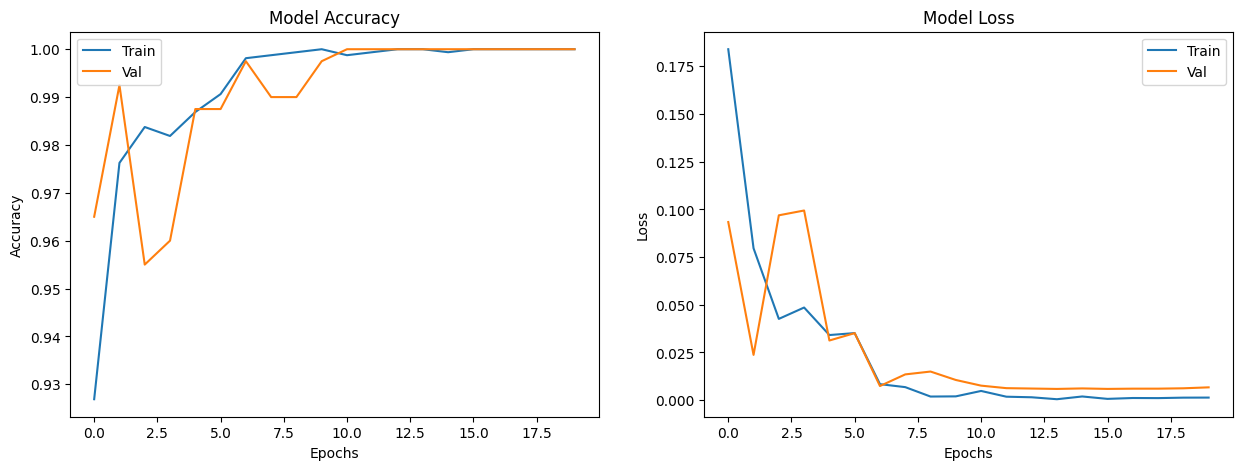

In [97]:
plot_accu_and_loss(*performance_efficientnet_b0_ft, file_name='efficientnet_b0_ft')

In [88]:
test_accuracy_efficientnet_b0_ft = calculate_test_accuracy(model_efficientnet_b0_ft, test_loader, device)
print(f'Test Accuracy: {test_accuracy_efficientnet_b0_ft * 100:.2f}%')

Test Accuracy: 77.75%


### ResNet50 as a Fixed Feature Extractor

In [89]:

# Load the pre-trained ResNet50 model with the default weights
weights = ResNet50_Weights.DEFAULT
model_resnet50_ffe = models.resnet50(weights=weights)

# Freeze all layers in the network
for param in model_resnet50_ffe.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# Number of features for the input layer of the fc
num_ftrs = model_resnet50_ffe.fc.in_features
# Replace the pre-trained model's final fully connected layer with a new one with 2 outputs
model_resnet50_ffe.fc = torch.nn.Linear(num_ftrs, 2)

# Move the model to the specified device
model_resnet50_ffe = model_resnet50_ffe.to(device)


train - Epoch 0/19 - Loss: 0.4384 - Acc: 0.8550
val - Epoch 0/19 - Loss: 0.2838 - Acc: 0.9325
train - Epoch 1/19 - Loss: 0.2560 - Acc: 0.9269
val - Epoch 1/19 - Loss: 0.2139 - Acc: 0.9325
train - Epoch 2/19 - Loss: 0.2080 - Acc: 0.9363
val - Epoch 2/19 - Loss: 0.1781 - Acc: 0.9375
train - Epoch 3/19 - Loss: 0.1872 - Acc: 0.9375
val - Epoch 3/19 - Loss: 0.1595 - Acc: 0.9450
train - Epoch 4/19 - Loss: 0.1699 - Acc: 0.9469
val - Epoch 4/19 - Loss: 0.1585 - Acc: 0.9400
train - Epoch 5/19 - Loss: 0.1566 - Acc: 0.9513
val - Epoch 5/19 - Loss: 0.1417 - Acc: 0.9425
train - Epoch 6/19 - Loss: 0.1475 - Acc: 0.9563
val - Epoch 6/19 - Loss: 0.1432 - Acc: 0.9375
train - Epoch 7/19 - Loss: 0.1488 - Acc: 0.9506
val - Epoch 7/19 - Loss: 0.1374 - Acc: 0.9475
train - Epoch 8/19 - Loss: 0.1369 - Acc: 0.9606
val - Epoch 8/19 - Loss: 0.1298 - Acc: 0.9550
train - Epoch 9/19 - Loss: 0.1416 - Acc: 0.9537
val - Epoch 9/19 - Loss: 0.1378 - Acc: 0.9525
train - Epoch 10/19 - Loss: 0.1363 - Acc: 0.9581
val - Epoch

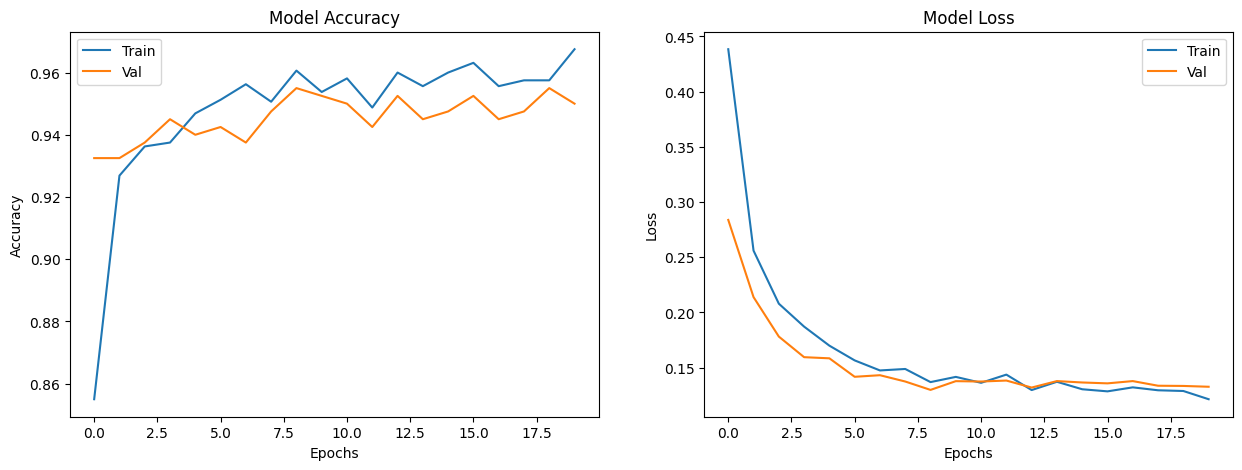

In [90]:
# Call the train_model function to train the network
model_resnet50_ffe, *performance_resnet50_ffe = train_model(model_resnet50_ffe, num_epochs=20)

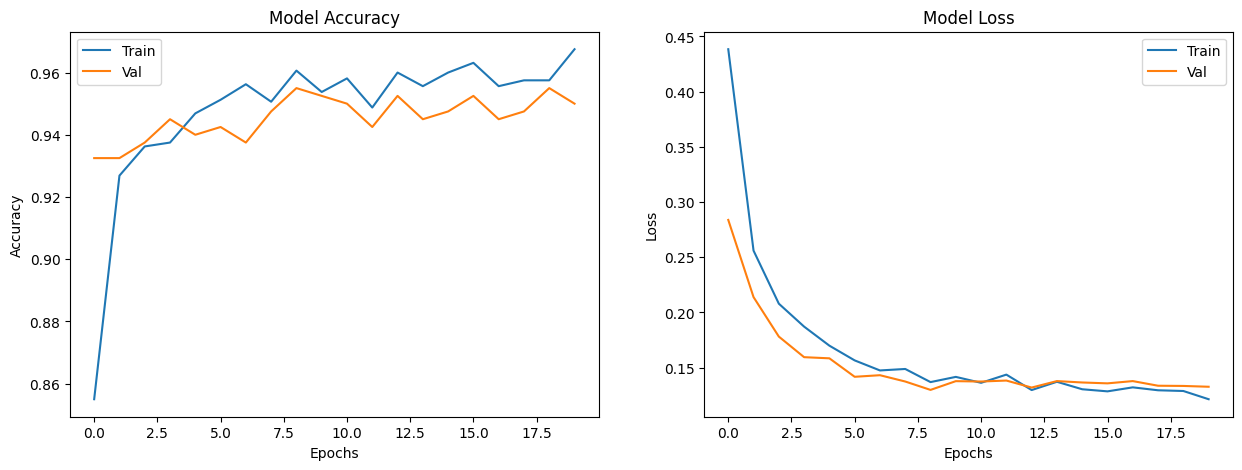

In [98]:
plot_accu_and_loss(*performance_resnet50_ffe, file_name='resnet50_ffe')

In [93]:

test_accuracy_resnet50_ffe = calculate_test_accuracy(model_resnet50_ffe, test_loader, device)
print(f'Test Accuracy: {test_accuracy_resnet50_ffe * 100:.2f}%')

Test Accuracy: 84.00%


### EfficientNet as a Fixed Feature Extractor

In [91]:
from torchvision import models
from torchvision.models import EfficientNet_B0_Weights

# Load the pre-trained EfficientNet B0 model with the default weights
weights = EfficientNet_B0_Weights.DEFAULT
model_efficientnet_b0_ffe = models.efficientnet_b0(weights=weights)

# Freeze all layers in the network
for param in model_efficientnet_b0_ffe.parameters():
    param.requires_grad = False

# Replace the classifier with a new one with 2 outputs
num_ftrs = model_efficientnet_b0_ffe.classifier[1].in_features
model_efficientnet_b0_ffe.classifier[1] = torch.nn.Linear(num_ftrs, 2)

# Move the model to the specified device
model_efficientnet_b0_ffe = model_efficientnet_b0_ffe.to(device)


train - Epoch 0/19 - Loss: 0.3923 - Acc: 0.8419
val - Epoch 0/19 - Loss: 0.2346 - Acc: 0.9325
train - Epoch 1/19 - Loss: 0.2283 - Acc: 0.9231
val - Epoch 1/19 - Loss: 0.1907 - Acc: 0.9425
train - Epoch 2/19 - Loss: 0.2113 - Acc: 0.9244
val - Epoch 2/19 - Loss: 0.1813 - Acc: 0.9500
train - Epoch 3/19 - Loss: 0.1856 - Acc: 0.9350
val - Epoch 3/19 - Loss: 0.1680 - Acc: 0.9525
train - Epoch 4/19 - Loss: 0.1748 - Acc: 0.9425
val - Epoch 4/19 - Loss: 0.1565 - Acc: 0.9475
train - Epoch 5/19 - Loss: 0.1429 - Acc: 0.9481
val - Epoch 5/19 - Loss: 0.1569 - Acc: 0.9475
train - Epoch 6/19 - Loss: 0.1611 - Acc: 0.9400
val - Epoch 6/19 - Loss: 0.1509 - Acc: 0.9525
train - Epoch 7/19 - Loss: 0.1488 - Acc: 0.9456
val - Epoch 7/19 - Loss: 0.1536 - Acc: 0.9500
train - Epoch 8/19 - Loss: 0.1531 - Acc: 0.9425
val - Epoch 8/19 - Loss: 0.1496 - Acc: 0.9525
train - Epoch 9/19 - Loss: 0.1490 - Acc: 0.9413
val - Epoch 9/19 - Loss: 0.1486 - Acc: 0.9475
train - Epoch 10/19 - Loss: 0.1495 - Acc: 0.9437
val - Epoch

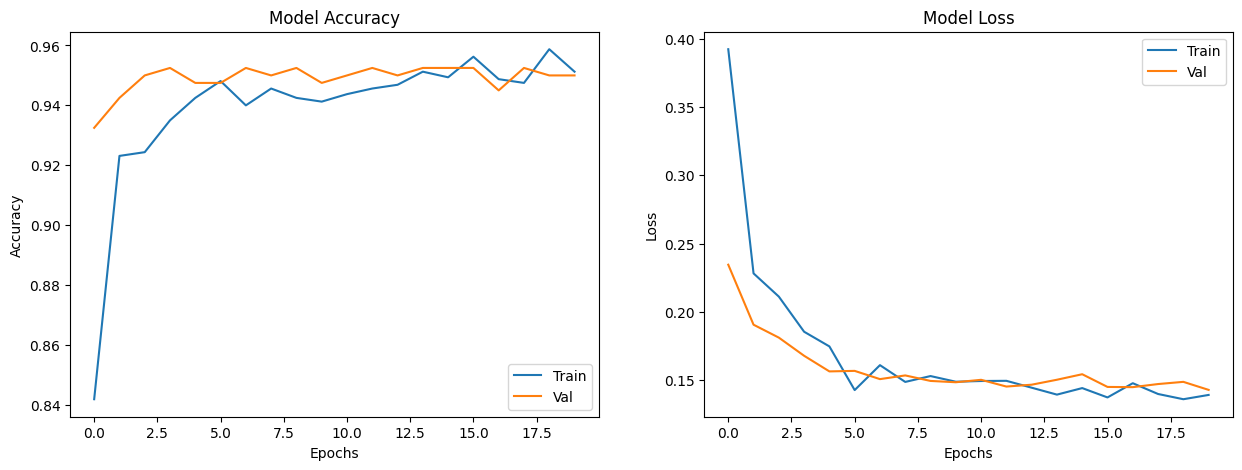

In [92]:
# Call the train_model function to train the network
model_efficientnet_b0_ffe, *performance_efficientnet_b0_ffe = train_model(model_efficientnet_b0_ffe, num_epochs=20)

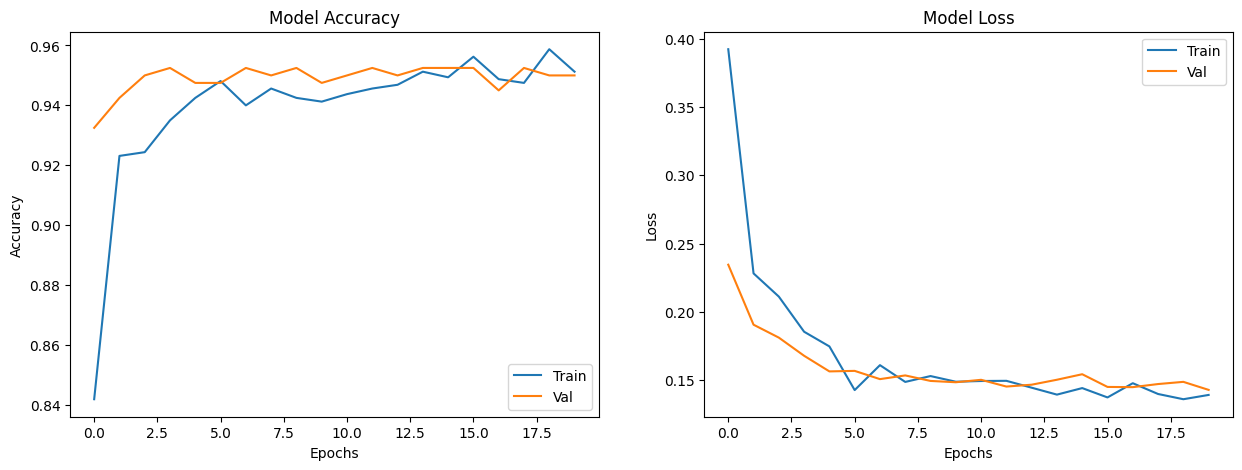

In [99]:
plot_accu_and_loss(*performance_efficientnet_b0_ffe, file_name='efficientnet_b0_ffe')

In [94]:

test_accuracy_efficientnet_b0_ffe = calculate_test_accuracy(model_efficientnet_b0_ffe, test_loader, device)
print(f'Test Accuracy: {test_accuracy_efficientnet_b0_ffe * 100:.2f}%')

Test Accuracy: 81.75%


train - Epoch 0/19 - Loss: 0.0611 - Acc: 0.9756
val - Epoch 0/19 - Loss: 0.1271 - Acc: 0.9450
train - Epoch 1/19 - Loss: 0.0226 - Acc: 0.9919
val - Epoch 1/19 - Loss: 0.1916 - Acc: 0.9225
train - Epoch 2/19 - Loss: 0.0171 - Acc: 0.9919
val - Epoch 2/19 - Loss: 1.5246 - Acc: 0.8050
train - Epoch 3/19 - Loss: 0.0452 - Acc: 0.9856
val - Epoch 3/19 - Loss: 0.4975 - Acc: 0.8400
train - Epoch 4/19 - Loss: 0.0259 - Acc: 0.9931
val - Epoch 4/19 - Loss: 0.2224 - Acc: 0.9250
train - Epoch 5/19 - Loss: 0.0224 - Acc: 0.9913
val - Epoch 5/19 - Loss: 0.3895 - Acc: 0.9275
train - Epoch 6/19 - Loss: 0.0184 - Acc: 0.9944
val - Epoch 6/19 - Loss: 0.1652 - Acc: 0.9675
train - Epoch 7/19 - Loss: 0.0111 - Acc: 0.9962
val - Epoch 7/19 - Loss: 0.0514 - Acc: 0.9775
train - Epoch 8/19 - Loss: 0.0024 - Acc: 0.9994
val - Epoch 8/19 - Loss: 0.0485 - Acc: 0.9800
train - Epoch 9/19 - Loss: 0.0019 - Acc: 1.0000
val - Epoch 9/19 - Loss: 0.0453 - Acc: 0.9825
train - Epoch 10/19 - Loss: 0.0034 - Acc: 0.9994
val - Epoch

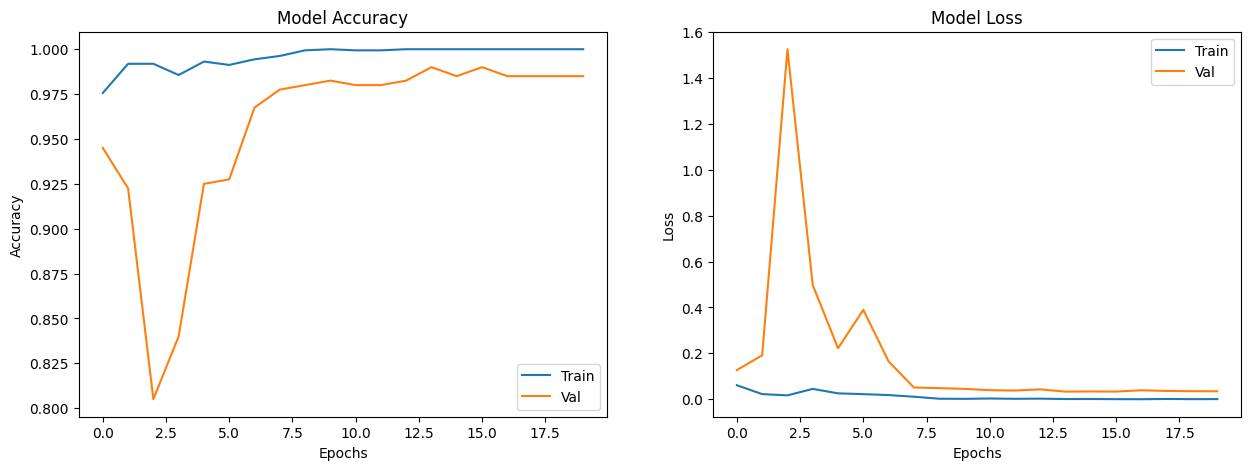

In [104]:
a, *b = train_model(model_resnet50_ft, num_epochs=20)

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
train - Epoch 0/19 - Loss: 0.2042 - Acc: 0.9181
val - Epoch 0/19 - Loss: 16.2278 - Acc: 0.5000
train - Epoch 1/19 - Loss: 0.1094 - Acc: 0.9569
val - Epoch 1/19 - Loss: 0.4151 - Acc: 0.8200
train - Epoch 2/19 - Loss: 0.0507 - Acc: 0.9825
val - Epoch 2/19 - Loss: 0.1449 - Acc: 0.9700
train - Epoch 3/19 - Loss: 0.0481 - Acc: 0.9800
val - Epoch 3/19 - Loss: 1.0944 - Acc: 0.8325
train - Epoch 4/19 - Loss: 0.0503 - Acc: 0.9825
val - Epoch 4/19 - Loss: 0.4083 - Acc: 0.8275
train - Epoch 5/19 - Loss: 0.0739 - Acc: 0.9750
val - Epoch 5/19 - Loss: 3.1429 - Acc: 0.7025
train - Epoch 6/19 - Loss: 0.0920 - Acc: 0.9681
val - Epoch 6/19 - Loss: 0.1521 - A

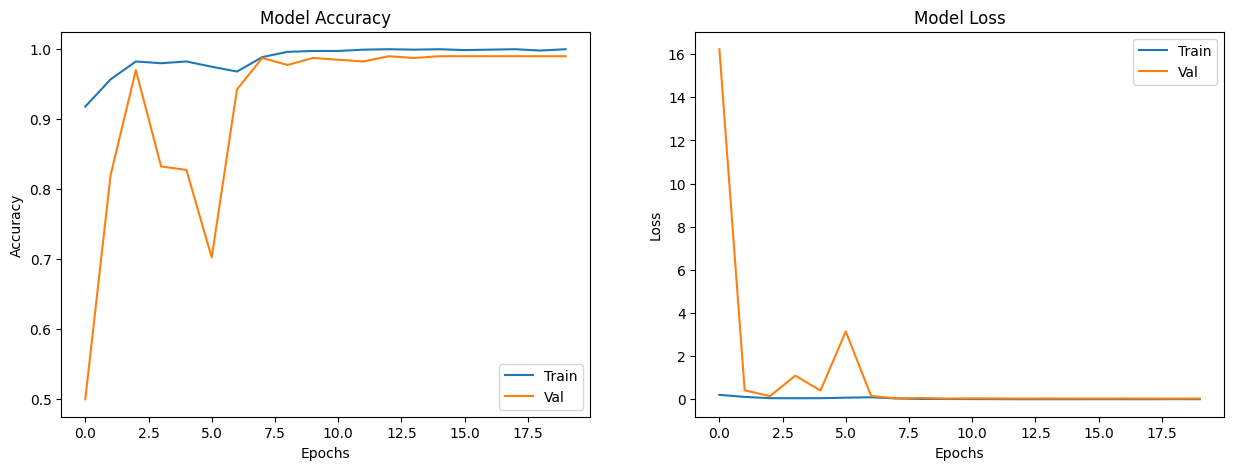

Test Accuracy: 78.25%


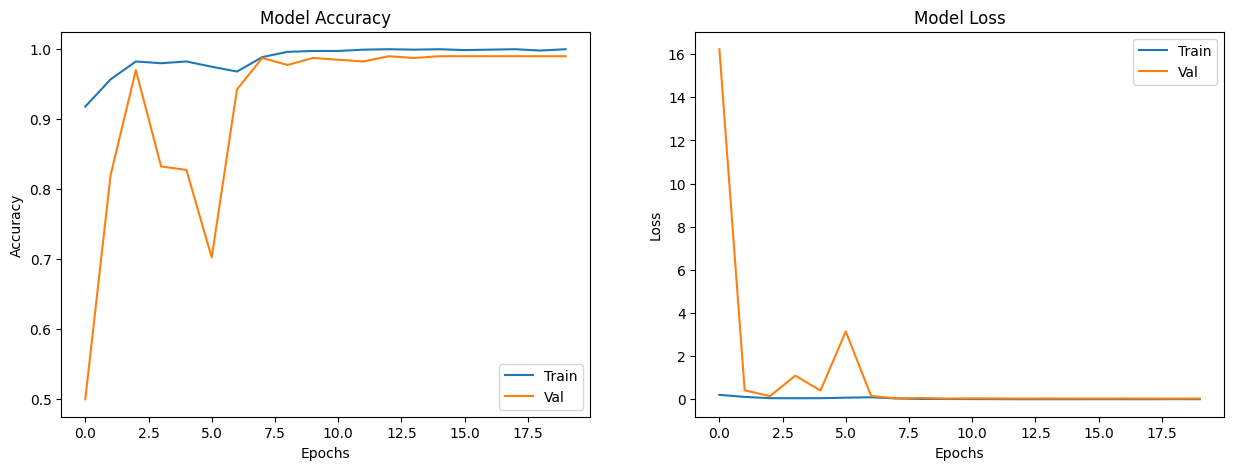

In [111]:
# get datasets
train_loader, val_loader, test_loader = get_datasets()
model_resnet50_ft = get_model('ResNet50', False)

# Call the train_model function to train the network
model_resnet50_ft, *performance_resnet50_ft = train_model(model_resnet50_ft, num_epochs=20)

# Calculate the test accuracy
test_accuracy_resnet50_ft = calculate_test_accuracy(model_resnet50_ft, test_loader, device)
print(f'Test Accuracy: {test_accuracy_resnet50_ft * 100:.2f}%')

plot_accu_and_loss(*performance_resnet50_ft, file_name='resnet50_ft_002')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
train - Epoch 0/19 - Loss: 0.6321 - Acc: 0.8931
val - Epoch 0/19 - Loss: 0.1332 - Acc: 0.9325
train - Epoch 1/19 - Loss: 0.0928 - Acc: 0.9700
val - Epoch 1/19 - Loss: 0.0542 - Acc: 0.9850
train - Epoch 2/19 - Loss: 0.0621 - Acc: 0.9750
val - Epoch 2/19 - Loss: 0.0472 - Acc: 0.9800
train - Epoch 3/19 - Loss: 0.0532 - Acc: 0.9856
val - Epoch 3/19 - Loss: 0.0433 - Acc: 0.9900
train - Epoch 4/19 - Loss: 0.0233 - Acc: 0.9931
val - Epoch 4/19 - Loss: 0.0353 - Acc: 0.9875
train - Epoch 5/19 - Loss: 0.0096 - Acc: 0.9969
val - Epoch 5/19 - Loss: 0.0251 - Acc: 0.9850
train - Epoch 6/19 - Loss: 0.0095 - Acc: 0.9969
val - Epoch 6/19 - Loss: 0.0321 - Ac

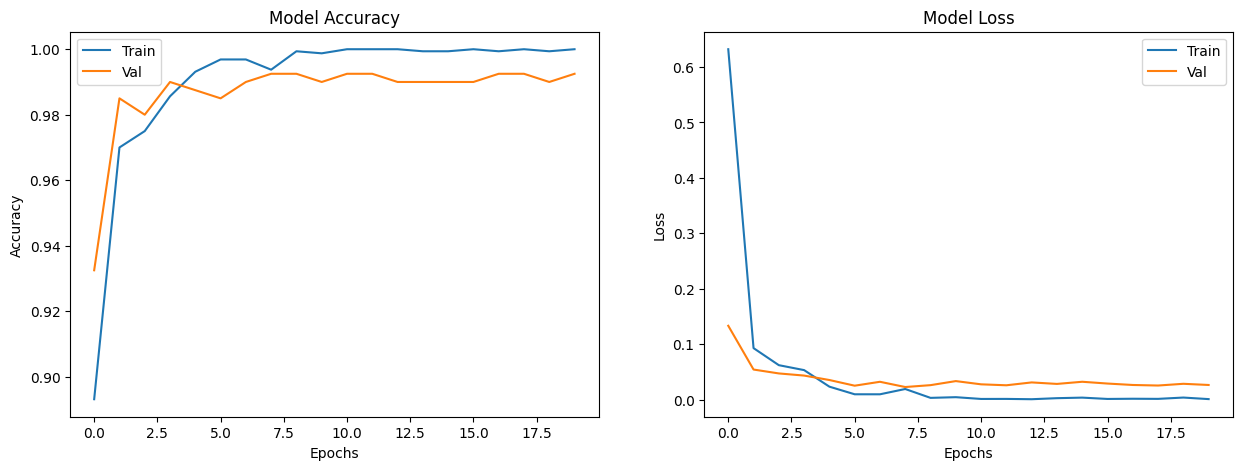

Test Accuracy: 76.75%


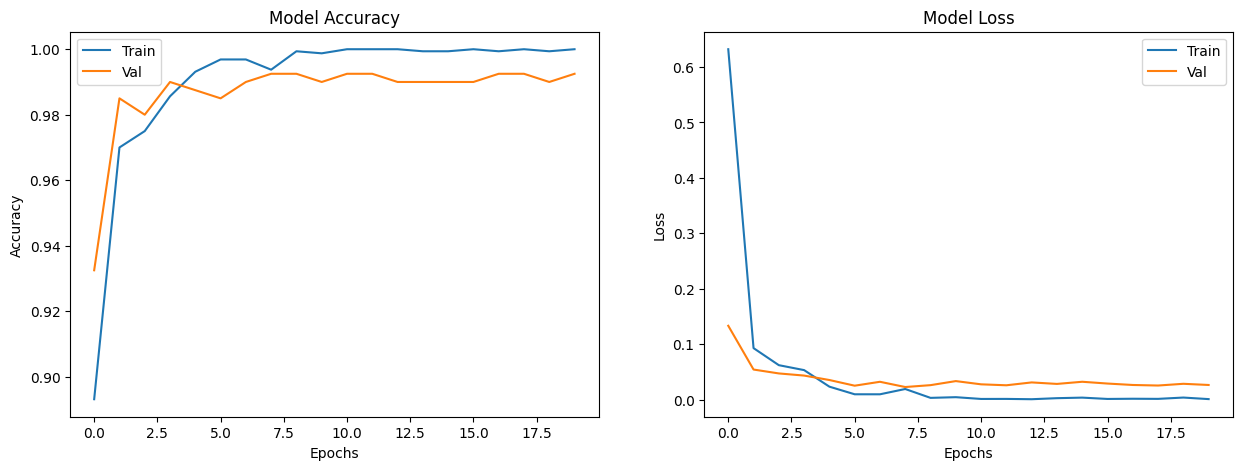

In [113]:
# get datasets
train_loader, val_loader, test_loader = get_datasets()
model_effiecientnet_b0_ft = get_model('EfficientNet-B0', False)

# Call the train_model function to train the network
model_effiecientnet_b0_ft, *performance_effiecientnet_b0_ft = train_model(model_effiecientnet_b0_ft, 
                                                                          num_epochs=20)

# Calculate the test accuracy
test_accuracy_effiecientnet_b0_ft = calculate_test_accuracy(model_effiecientnet_b0_ft, 
                                                            test_loader, device)
print(f'Test Accuracy: {test_accuracy_effiecientnet_b0_ft * 100:.2f}%')

plot_accu_and_loss(*performance_effiecientnet_b0_ft, file_name='effiecientnet_b0_ft_002')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
train - Epoch 0/19 - Loss: 0.4421 - Acc: 0.7869
val - Epoch 0/19 - Loss: 0.2296 - Acc: 0.9375
train - Epoch 1/19 - Loss: 0.2249 - Acc: 0.9213
val - Epoch 1/19 - Loss: 0.1833 - Acc: 0.9425
train - Epoch 2/19 - Loss: 0.2038 - Acc: 0.9238
val - Epoch 2/19 - Loss: 0.1677 - Acc: 0.9350
train - Epoch 3/19 - Loss: 0.1816 - Acc: 0.9337
val - Epoch 3/19 - Loss: 0.1561 - Acc: 0.9500
train - Epoch 4/19 - Loss: 0.1605 - Acc: 0.9437
val - Epoch 4/19 - Loss: 0.1456 - Acc: 0.9525
train - Epoch 5/19 - Loss: 0.1659 - Acc: 0.9356
val - Epoch 5/19 - Loss: 0.1434 - Acc: 0.9600
train - Epoch 6/19 - Loss: 0.1865 - Acc: 0.9263
val - Epoch 6/19 - Loss: 0.1498 - Ac

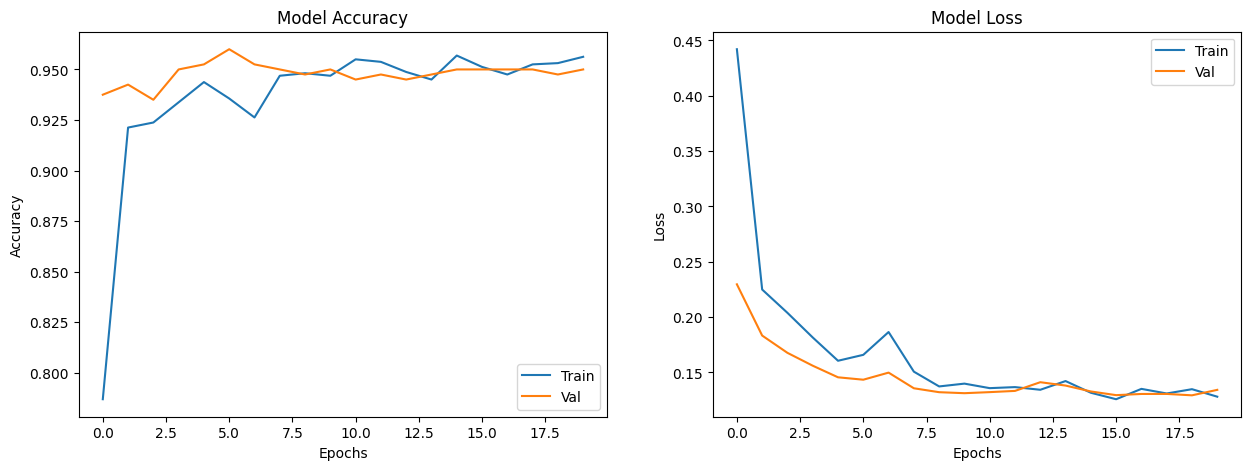

Test Accuracy: 83.75%


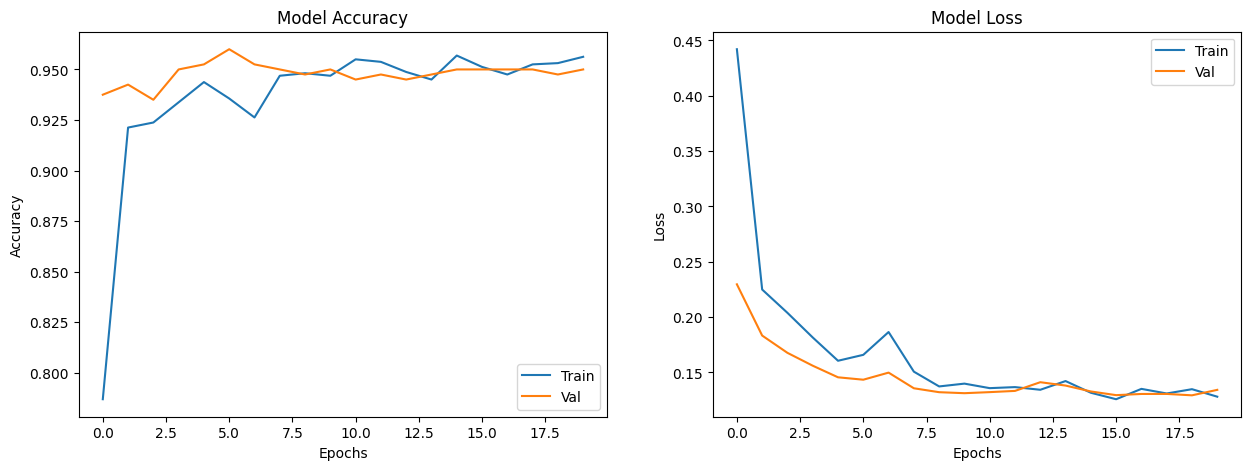

In [115]:
# get datasets
train_loader, val_loader, test_loader = get_datasets()
model_resnet50_ffe = get_model('ResNet50', True)

# Call the train_model function to train the network
model_resnet50_ffe, *performance_resnet50_ffe = train_model(model_resnet50_ffe, num_epochs=20)

# Calculate the test accuracy
test_accuracy_resnet50_ffe = calculate_test_accuracy(model_resnet50_ffe, test_loader, device)
print(f'Test Accuracy: {test_accuracy_resnet50_ffe * 100:.2f}%')

plot_accu_and_loss(*performance_resnet50_ffe, file_name='resnet50_ffe_002')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
train - Epoch 0/19 - Loss: 0.3660 - Acc: 0.8681
val - Epoch 0/19 - Loss: 0.2273 - Acc: 0.9350
train - Epoch 1/19 - Loss: 0.2216 - Acc: 0.9250
val - Epoch 1/19 - Loss: 0.1849 - Acc: 0.9425
train - Epoch 2/19 - Loss: 0.1998 - Acc: 0.9269
val - Epoch 2/19 - Loss: 0.1852 - Acc: 0.9475
train - Epoch 3/19 - Loss: 0.1733 - Acc: 0.9381
val - Epoch 3/19 - Loss: 0.1664 - Acc: 0.9525
train - Epoch 4/19 - Loss: 0.1706 - Acc: 0.9400
val - Epoch 4/19 - Loss: 0.1603 - Acc: 0.9500
train - Epoch 5/19 - Loss: 0.1628 - Acc: 0.9394
val - Epoch 5/19 - Loss: 0.1643 - Acc: 0.9500
train - Epoch 6/19 - Loss: 0.1459 - Acc: 0.9513
val - Epoch 6/19 - Loss: 0.1546 - Ac

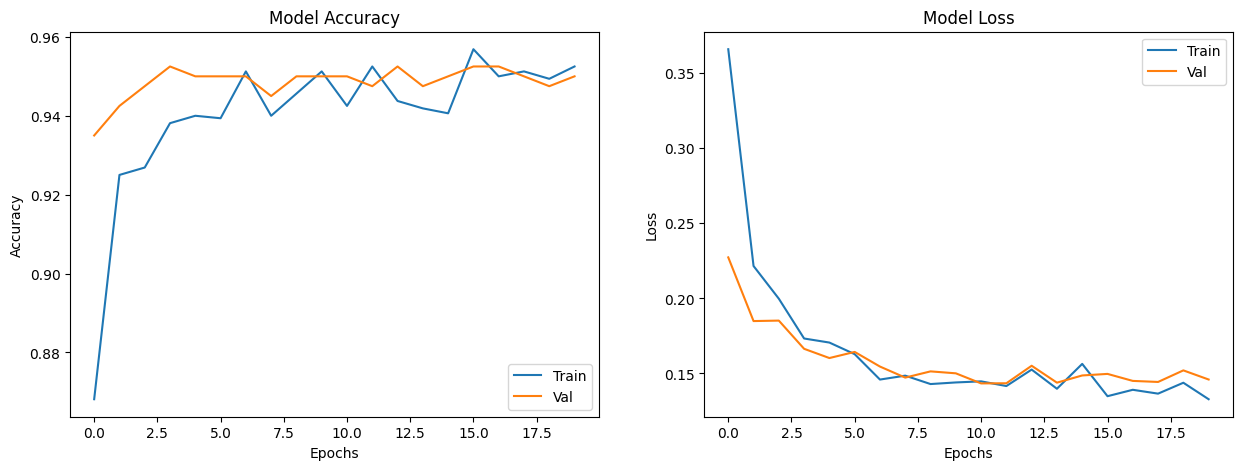

Test Accuracy: 83.50%


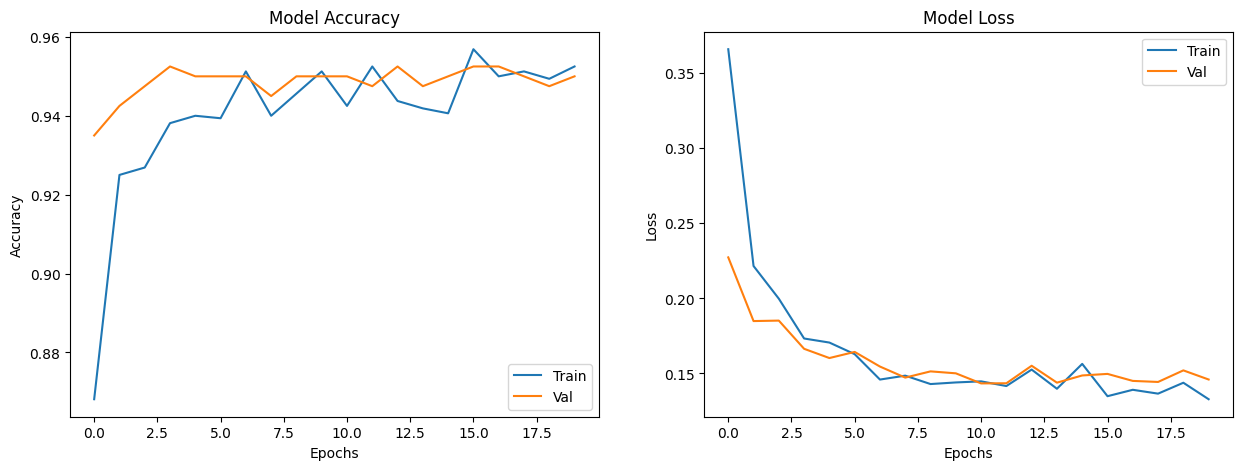

In [118]:
# get datasets
train_loader, val_loader, test_loader = get_datasets()
model_effiecientnet_b0_ffe = get_model('EfficientNet-B0', True)

# Call the train_model function to train the network
model_effiecientnet_b0_ffe, *performance_effiecientnet_b0_ffe = train_model(model_effiecientnet_b0_ffe, 
                                                                            num_epochs=20)

# Calculate the test accuracy
test_accuracy_effiecientnet_b0_ffe = calculate_test_accuracy(model_effiecientnet_b0_ffe, 
                                                             test_loader, device)
print(f'Test Accuracy: {test_accuracy_effiecientnet_b0_ffe * 100:.2f}%')

plot_accu_and_loss(*performance_effiecientnet_b0_ffe, file_name='effiecientnet_b0_ffe_002')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
train - Epoch 0/19 - Loss: 1.2287 - Acc: 0.4475
val - Epoch 0/19 - Loss: 1.7390 - Acc: 0.4975
train - Epoch 1/19 - Loss: 0.5864 - Acc: 0.7275
val - Epoch 1/19 - Loss: 0.7137 - Acc: 0.5125
train - Epoch 2/19 - Loss: 0.8299 - Acc: 0.4650
val - Epoch 2/19 - Loss: 0.6648 - Acc: 0.5500
train - Epoch 3/19 - Loss: 0.8264 - Acc: 0.1925
val - Epoch 3/19 - Loss: 0.6562 - Acc: 0.6600
train - Epoch 4/19 - Loss: 0.7426 - Acc: 0.3400
val - Epoch 4/19 - Loss: 0.6461 - Acc: 0.6725
train - Epoch 5/19 - Loss: 0.7478 - Acc: 0.3825
val - Epoch 5/19 - Loss: 0.6385 - Acc: 0.6675
train - Epoch 6/19 - Loss: 0.7589 - Acc: 0.3600
val - Epoch 6/19 - Loss: 0.6351 - Ac

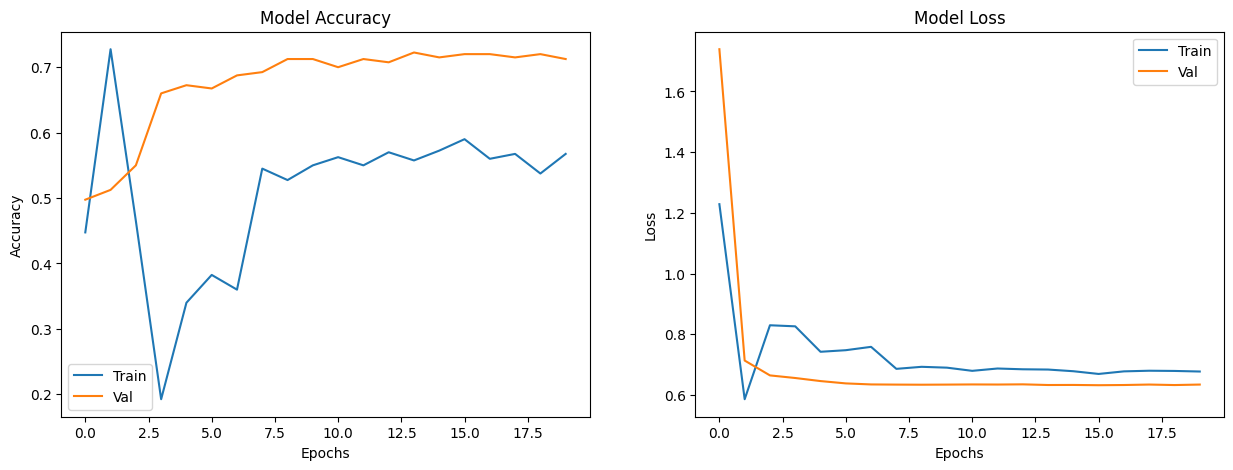

Test Accuracy: 69.81%


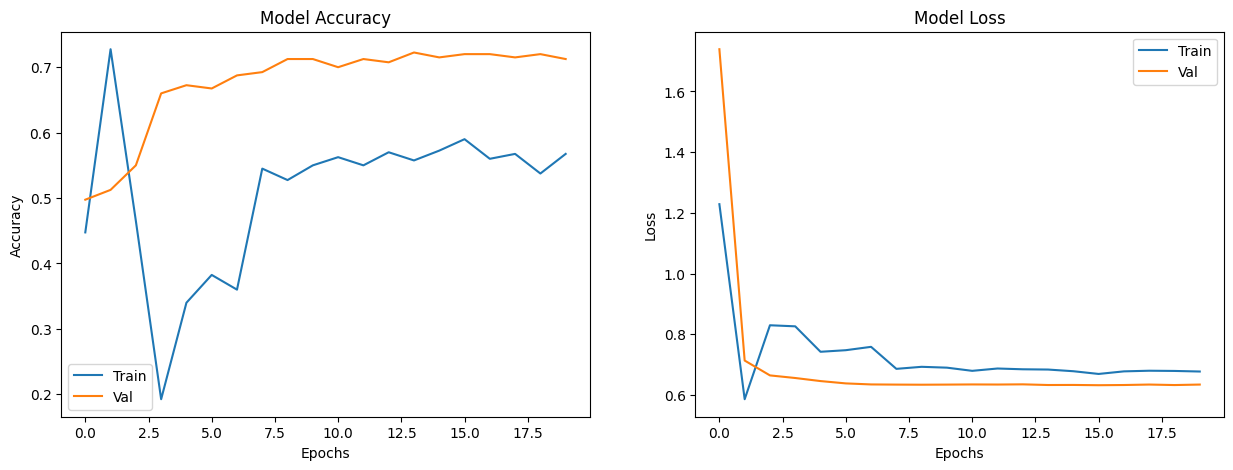

In [119]:
# get datasets
# train_loader, val_loader, test_loader = get_datasets()
test_loader, val_loader, train_loader = get_datasets()

model_effiecientnet_b0_ffe_test = get_model('EfficientNet-B0', True)

# Call the train_model function to train the network
model_effiecientnet_b0_ffe_test, *performance_effiecientnet_b0_ffe_test = train_model(model_effiecientnet_b0_ffe_test, 
                                                                            num_epochs=20)

# Calculate the test accuracy
test_accuracy_effiecientnet_b0_ffe_test = calculate_test_accuracy(model_effiecientnet_b0_ffe_test, 
                                                             test_loader, device)
print(f'Test Accuracy: {test_accuracy_effiecientnet_b0_ffe_test * 100:.2f}%')

plot_accu_and_loss(*performance_effiecientnet_b0_ffe_test, file_name=None)

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
train - Epoch 0/19 - Loss: 1.3675 - Acc: 0.5975
val - Epoch 0/19 - Loss: 2.9910 - Acc: 0.4800
train - Epoch 1/19 - Loss: 1.4440 - Acc: 0.0950
val - Epoch 1/19 - Loss: 0.6610 - Acc: 0.5100
train - Epoch 2/19 - Loss: 0.7370 - Acc: 0.3650
val - Epoch 2/19 - Loss: 0.6796 - Acc: 0.5000
train - Epoch 3/19 - Loss: 0.7934 - Acc: 0.3750
val - Epoch 3/19 - Loss: 0.5635 - Acc: 0.8425
train - Epoch 4/19 - Loss: 0.6534 - Acc: 0.5950
val - Epoch 4/19 - Loss: 0.4986 - Acc: 0.8300
train - Epoch 5/19 - Loss: 0.4285 - Acc: 0.7925
val - Epoch 5/19 - Loss: 0.6436 - Acc: 0.5825
train - Epoch 6/19 - Loss: 0.1782 - Acc: 0.9800
val - Epoch 6/19 - Loss: 0.4898 - Ac

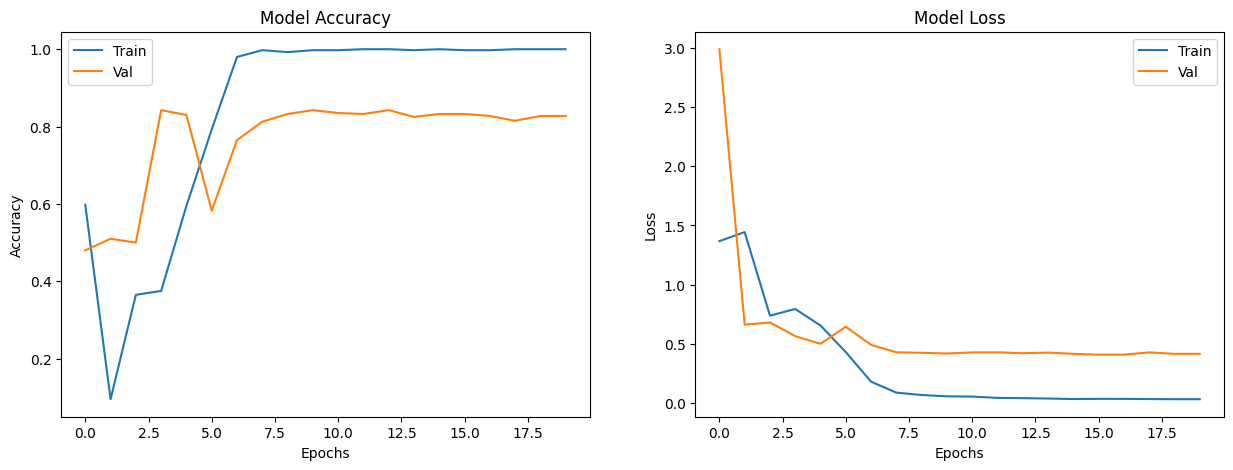

Test Accuracy: 80.19%


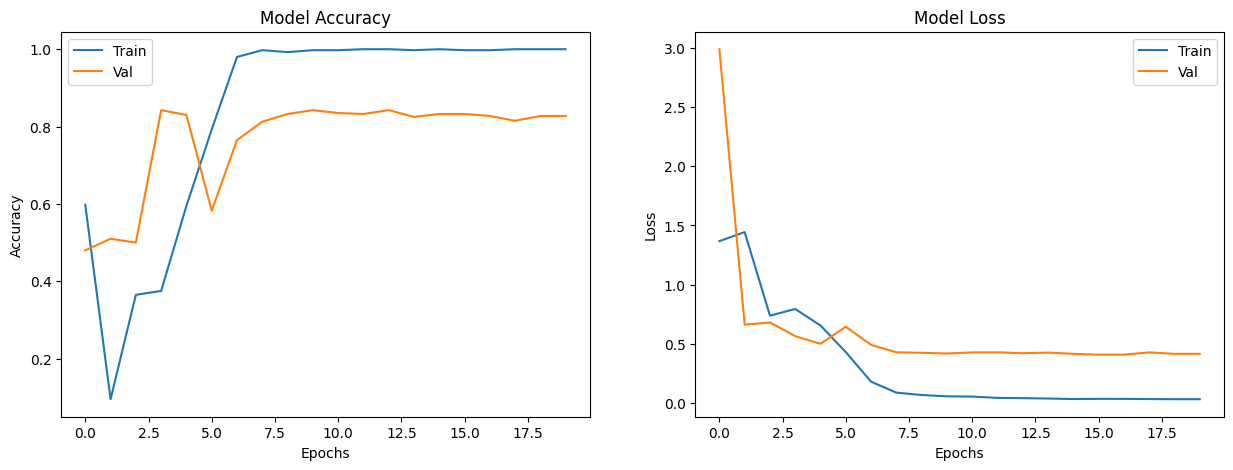

In [122]:
# get datasets
# train_loader, val_loader, test_loader = get_datasets()
test_loader, val_loader, train_loader = get_datasets()

model_effiecientnet_b0_ft_test = get_model('EfficientNet-B0', False)

# Call the train_model function to train the network
model_effiecientnet_b0_ft_test, *performance_effiecientnet_b0_ft_test = train_model(model_effiecientnet_b0_ft_test, 
                                                                            num_epochs=20)

# Calculate the test accuracy
test_accuracy_effiecientnet_b0_ft_test = calculate_test_accuracy(model_effiecientnet_b0_ft_test, 
                                                             test_loader, device)
print(f'Test Accuracy: {test_accuracy_effiecientnet_b0_ft_test * 100:.2f}%')

plot_accu_and_loss(*performance_effiecientnet_b0_ft_test, file_name='effiecientnet_b0_ft_test_001')

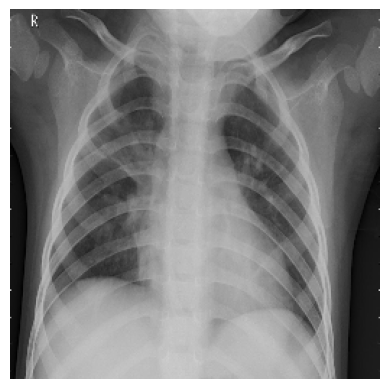

In [136]:
import matplotlib.pyplot as plt

# Let's assume `images` is your ndarray where each element in the array is an image
# and you want to display the first image
test_abnormal = np.load('test_pneumonia.npy')
first_image = test_abnormal[25]

# If the image has pixel values [0, 1], we multiply by 255.
# If it's already [0, 255], there's no need for this step.
if first_image.max() <= 1.0:
    first_image = first_image * 255

# Assuming the image is in a grayscale, you would do:
if len(first_image.shape) == 2 or first_image.shape[2] == 1:
    plt.imshow(first_image, cmap='gray')

# If it is an RGB image, you would do:
elif first_image.shape[2] == 3:
    plt.imshow(first_image.astype('uint8'))

plt.axis('off')  # to hide the axis
plt.show()


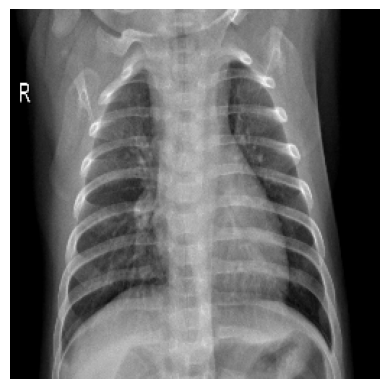

In [137]:
import matplotlib.pyplot as plt

# Let's assume `images` is your ndarray where each element in the array is an image
# and you want to display the first image
test_normal = np.load('test_normal.npy')
first_image = test_normal[25]

# If the image has pixel values [0, 1], we multiply by 255.
# If it's already [0, 255], there's no need for this step.
if first_image.max() <= 1.0:
    first_image = first_image * 255

# Assuming the image is in a grayscale, you would do:
if len(first_image.shape) == 2 or first_image.shape[2] == 1:
    plt.imshow(first_image, cmap='gray')

# If it is an RGB image, you would do:
elif first_image.shape[2] == 3:
    plt.imshow(first_image.astype('uint8'))

plt.axis('off')  # to hide the axis
plt.show()


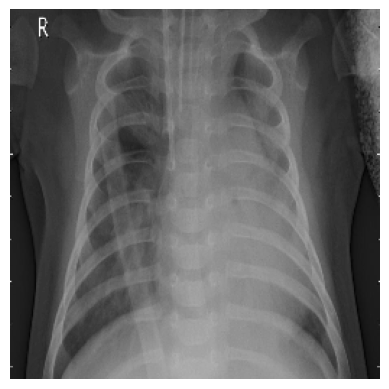

In [138]:
import matplotlib.pyplot as plt

# Let's assume `images` is your ndarray where each element in the array is an image
# and you want to display the first image
abnormal = np.load('pneumonia.npy')
first_image = abnormal[25]

# If the image has pixel values [0, 1], we multiply by 255.
# If it's already [0, 255], there's no need for this step.
if first_image.max() <= 1.0:
    first_image = first_image * 255

# Assuming the image is in a grayscale, you would do:
if len(first_image.shape) == 2 or first_image.shape[2] == 1:
    plt.imshow(first_image, cmap='gray')

# If it is an RGB image, you would do:
elif first_image.shape[2] == 3:
    plt.imshow(first_image.astype('uint8'))

plt.axis('off')  # to hide the axis
plt.show()


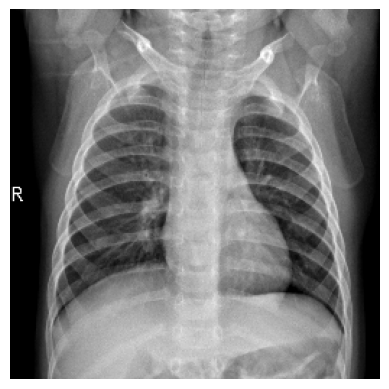

In [139]:
import matplotlib.pyplot as plt

# Let's assume `images` is your ndarray where each element in the array is an image
# and you want to display the first image
normal = np.load('normal.npy')
first_image = normal[25]

# If the image has pixel values [0, 1], we multiply by 255.
# If it's already [0, 255], there's no need for this step.
if first_image.max() <= 1.0:
    first_image = first_image * 255

# Assuming the image is in a grayscale, you would do:
if len(first_image.shape) == 2 or first_image.shape[2] == 1:
    plt.imshow(first_image, cmap='gray')

# If it is an RGB image, you would do:
elif first_image.shape[2] == 3:
    plt.imshow(first_image.astype('uint8'))

plt.axis('off')  # to hide the axis
plt.show()


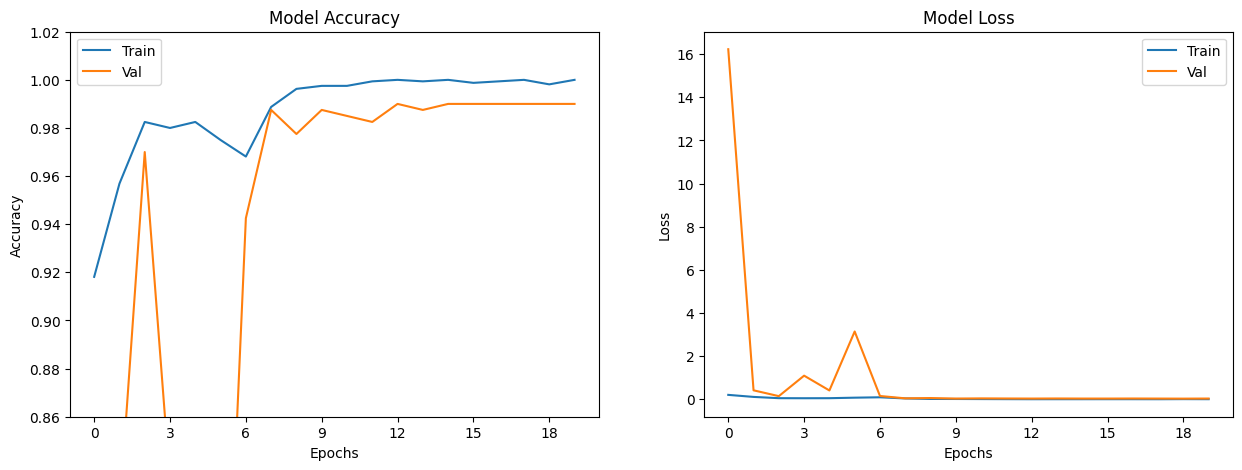

In [163]:
plot_accu_and_loss(*performance_resnet50_ft, file_name='resnet50_ft_002')

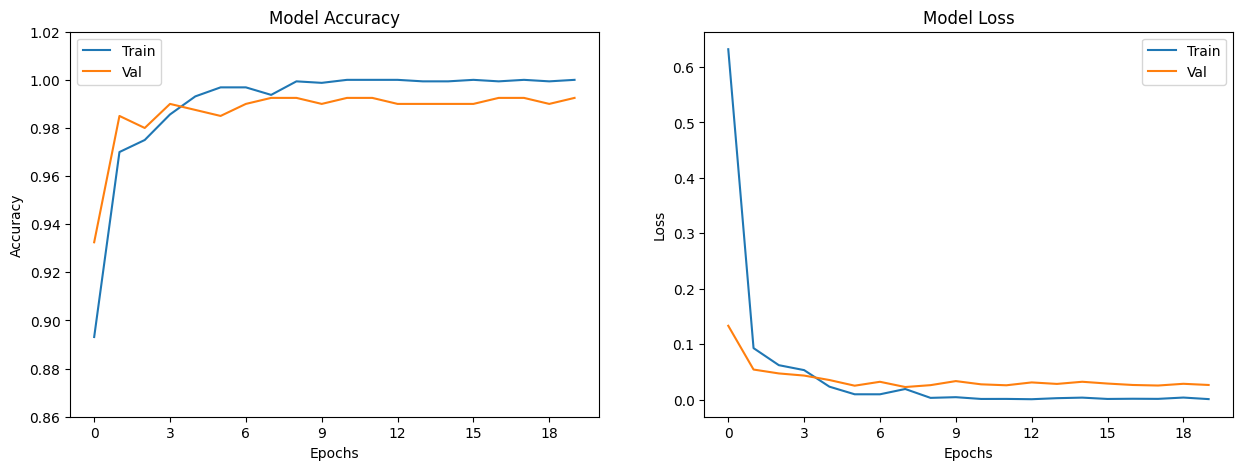

In [164]:
plot_accu_and_loss(*performance_effiecientnet_b0_ft, file_name='effiecientnet_b0_ft_002')

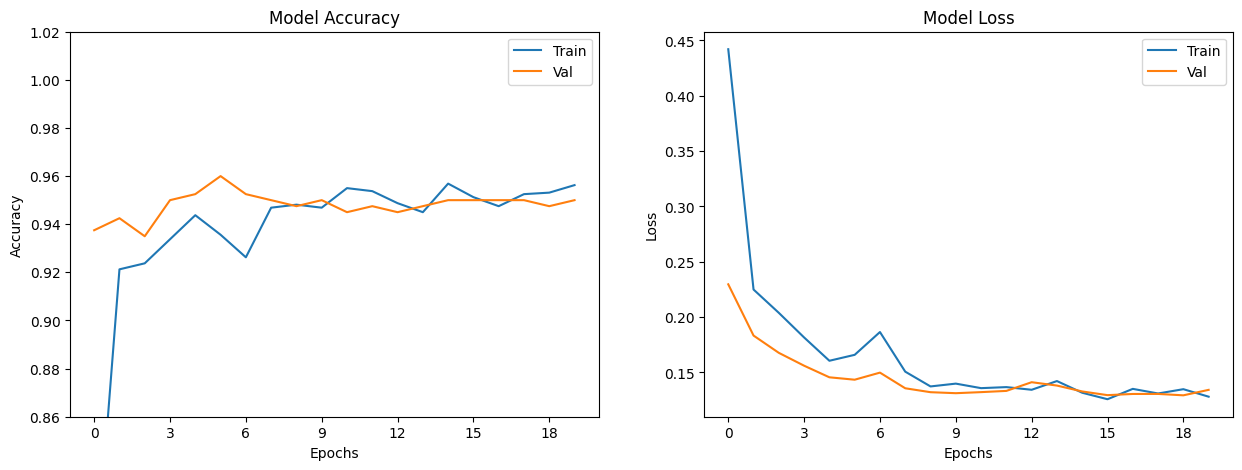

In [165]:
plot_accu_and_loss(*performance_resnet50_ffe, file_name='resnet50_ffe_002')

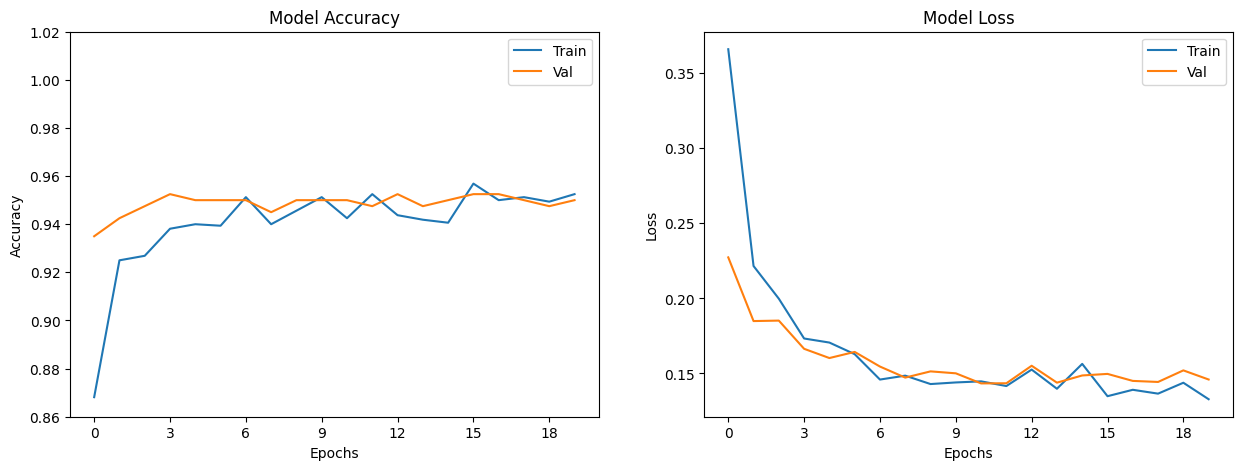

In [169]:
plot_accu_and_loss(*performance_effiecientnet_b0_ffe, file_name='effiecientnet_b0_ffe_002')

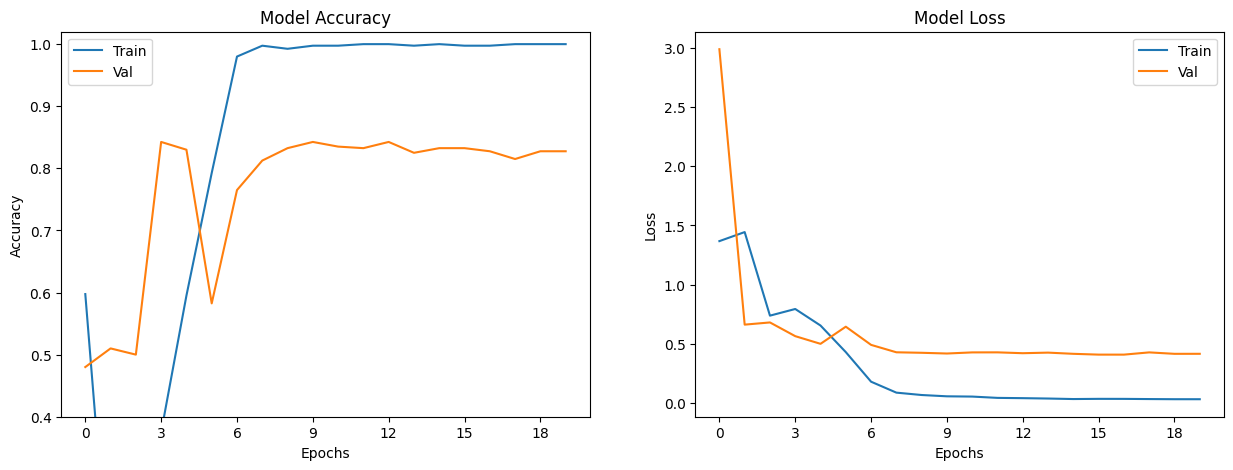

In [173]:
plot_accu_and_loss(*performance_effiecientnet_b0_ft_test, 
                   file_name='effiecientnet_b0_ft_test_001',
                   ylim=(0.4, 1.02))

### Time Comaprison

In [193]:
def get_training_time(model_name, fixed_feature=False, series_no='gb'):
    time_start = time.time()
    
    # get datasets
    train_loader, val_loader, test_loader = get_datasets()
    
    # get_model
    model = get_model(model_name, fixed_feature)

    # Call the train_model function to train the network
    model, *performance = train_model(model, train_loader=train_loader, val_loader=val_loader, num_epochs=20)

    # Calculate the test accuracy
    test_accuracy = calculate_test_accuracy(model, test_loader, device)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    plot_accu_and_loss(*performance, file_name=f'{model_name}_{series_no}')
    
    time_end = time.time()
    
    time_consumption = time_end - time_start
    
    print(f'Time Consumption of the Model - {model_name} : {time_consumption:.2f} seconds.')
    
    return model, *performance, test_accuracy, time_consumption

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
train - Epoch 0/19 - Loss: 0.2100 - Acc: 0.9169
val - Epoch 0/19 - Loss: 2.2848 - Acc: 0.6225
train - Epoch 1/19 - Loss: 0.1144 - Acc: 0.9587
val - Epoch 1/19 - Loss: 0.1707 - Acc: 0.9200
train - Epoch 2/19 - Loss: 0.1177 - Acc: 0.9563
val - Epoch 2/19 - Loss: 1.8672 - Acc: 0.5875
train - Epoch 3/19 - Loss: 0.0743 - Acc: 0.9731
val - Epoch 3/19 - Loss: 0.3175 - Acc: 0.9225
train - Epoch 4/19 - Loss: 0.0656 - Acc: 0.9769
val - Epoch 4/19 - Loss: 2.0785 - Acc: 0.6775
train - Epoch 5/19 - Loss: 0.0517 - Acc: 0.9825
val - Epoch 5/19 - Loss: 0.1080 - Acc: 0.9475
train - Epoch 6/19 - Loss: 0.0169 - Acc: 0.9931
val - Epoch 6/19 - Loss: 0.5907 - Ac

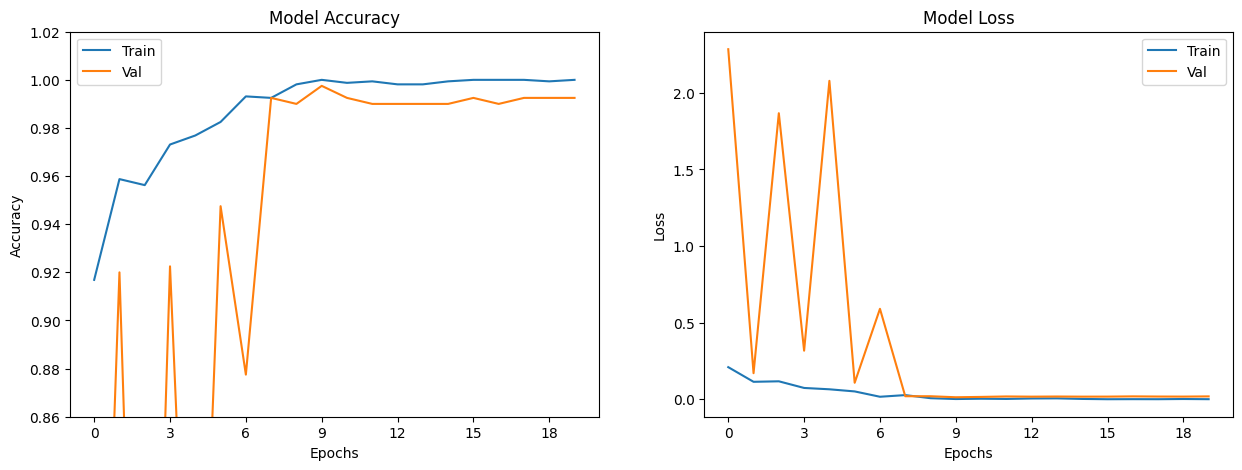

Test Accuracy: 78.25%


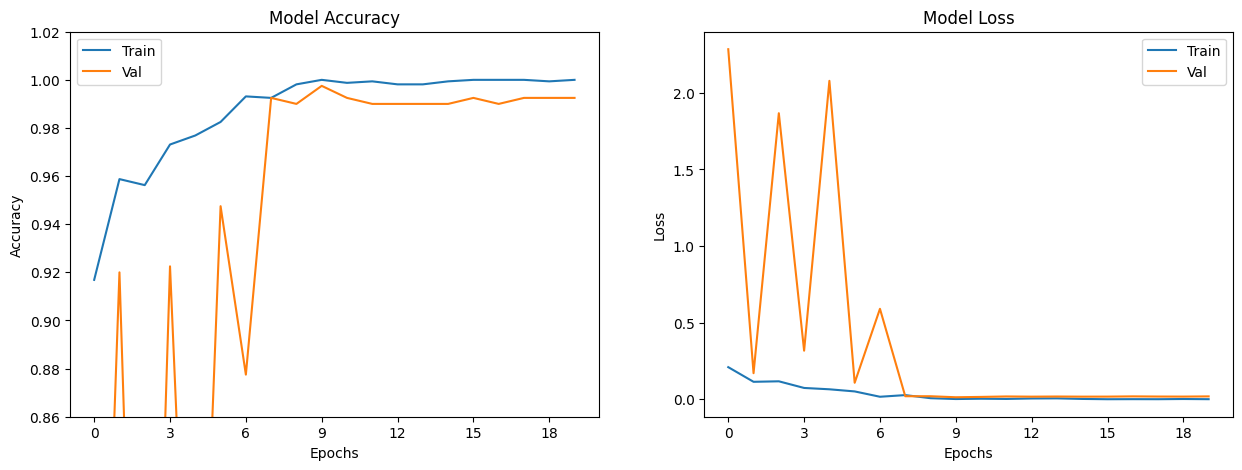

Time Consumption of the Model - ResNet50 : 102.45 seconds.


In [200]:
model_resnet50_ft_003_tuple = get_training_time('ResNet50', fixed_feature=False, series_no='003')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
train - Epoch 0/19 - Loss: 0.1748 - Acc: 0.9281
val - Epoch 0/19 - Loss: 0.0482 - Acc: 0.9825
train - Epoch 1/19 - Loss: 0.0833 - Acc: 0.9713
val - Epoch 1/19 - Loss: 0.0661 - Acc: 0.9775
train - Epoch 2/19 - Loss: 0.0544 - Acc: 0.9819
val - Epoch 2/19 - Loss: 0.0408 - Acc: 0.9900
train - Epoch 3/19 - Loss: 0.0267 - Acc: 0.9900
val - Epoch 3/19 - Loss: 0.0649 - Acc: 0.9800
train - Epoch 4/19 - Loss: 0.0130 - Acc: 0.9975
val - Epoch 4/19 - Loss: 0.0334 - Acc: 0.9850
train - Epoch 5/19 - Loss: 0.0100 - Acc: 0.9950
val - Epoch 5/19 - Loss: 0.0318 - Acc: 0.9925
train - Epoch 6/19 - Loss: 0.0230 - Acc: 0.9913
val - Epoch 6/19 - Loss: 0.0325 - Ac

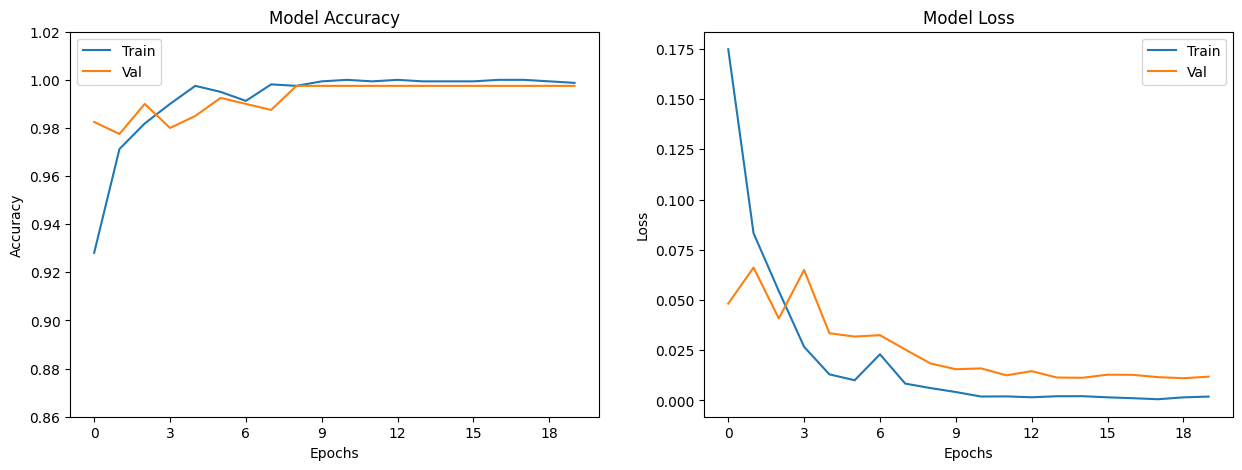

Test Accuracy: 77.75%


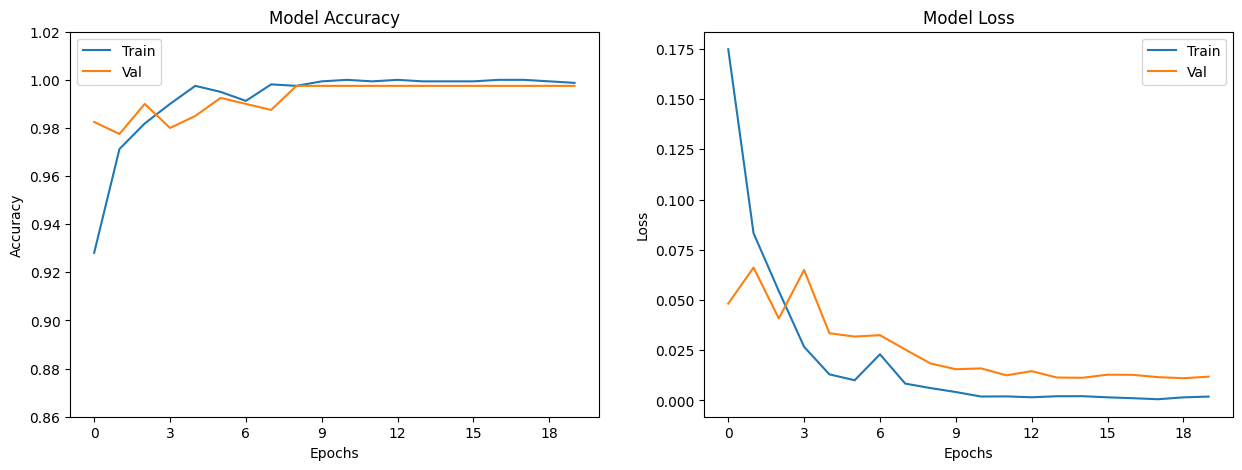

Time Consumption of the Model - EfficientNet-B0 : 68.18 seconds.


In [201]:
model_efficientnet_b0_ft_003_tuple = get_training_time('EfficientNet-B0', 
                                                                 fixed_feature=False, series_no='003')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
train - Epoch 0/19 - Loss: 0.3842 - Acc: 0.8425
val - Epoch 0/19 - Loss: 0.2314 - Acc: 0.9325
train - Epoch 1/19 - Loss: 0.2125 - Acc: 0.9287
val - Epoch 1/19 - Loss: 0.1771 - Acc: 0.9400
train - Epoch 2/19 - Loss: 0.1935 - Acc: 0.9231
val - Epoch 2/19 - Loss: 0.1753 - Acc: 0.9350
train - Epoch 3/19 - Loss: 0.1729 - Acc: 0.9356
val - Epoch 3/19 - Loss: 0.1583 - Acc: 0.9425
train - Epoch 4/19 - Loss: 0.1498 - Acc: 0.9431
val - Epoch 4/19 - Loss: 0.1435 - Acc: 0.9550
train - Epoch 5/19 - Loss: 0.1914 - Acc: 0.9250
val - Epoch 5/19 - Loss: 0.1382 - Acc: 0.9475
train - Epoch 6/19 - Loss: 0.1583 - Acc: 0.9406
val - Epoch 6/19 - Loss: 0.1413 - Ac

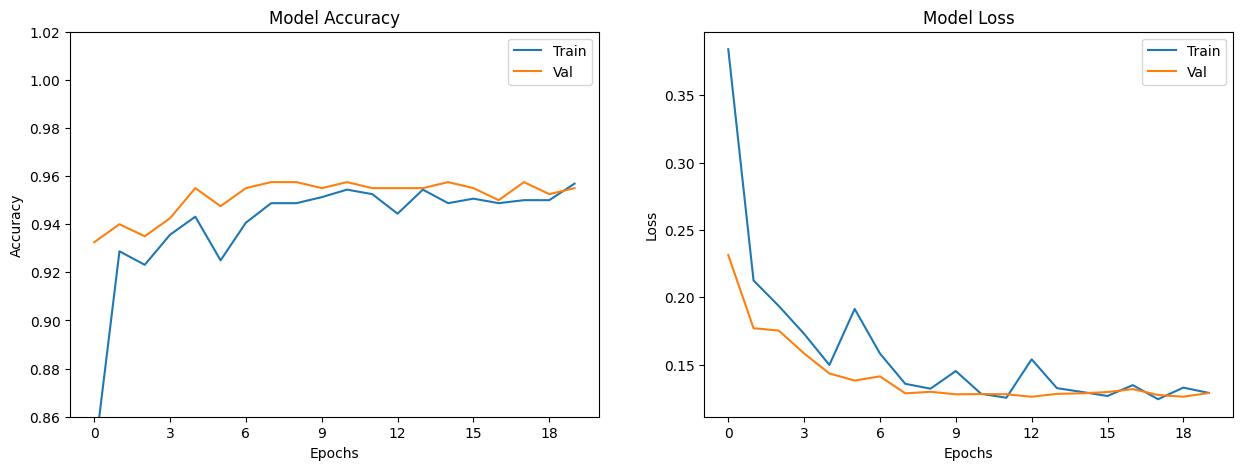

Test Accuracy: 83.00%


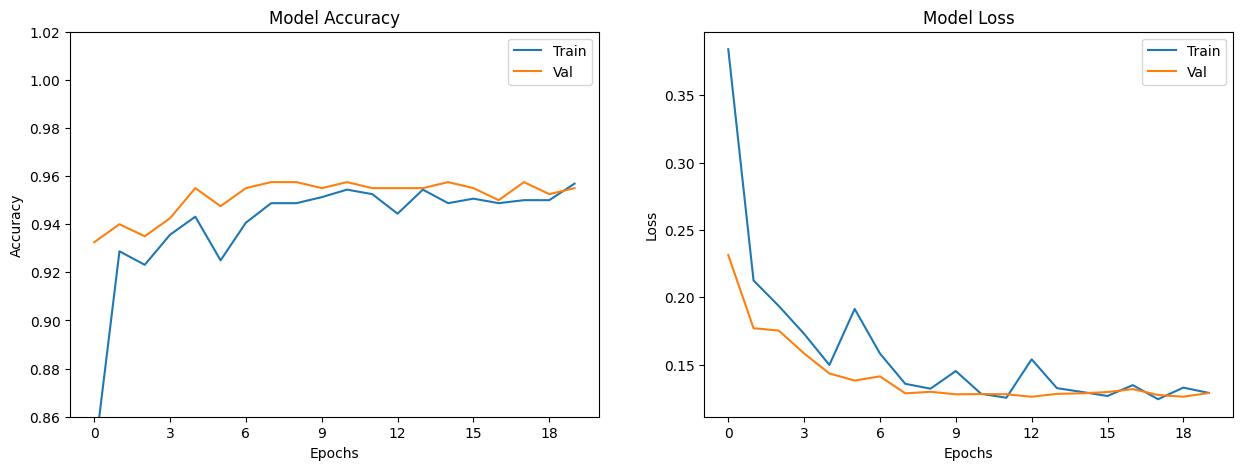

Time Consumption of the Model - ResNet50 : 45.33 seconds.


In [202]:
model_resnet50_ffe_003_tuple = get_training_time('ResNet50', fixed_feature=True, series_no='003')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.
Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)
train - Epoch 0/19 - Loss: 0.3756 - Acc: 0.8631
val - Epoch 0/19 - Loss: 0.2280 - Acc: 0.9350
train - Epoch 1/19 - Loss: 0.2223 - Acc: 0.9231
val - Epoch 1/19 - Loss: 0.1948 - Acc: 0.9475
train - Epoch 2/19 - Loss: 0.1921 - Acc: 0.9250
val - Epoch 2/19 - Loss: 0.1746 - Acc: 0.9425
train - Epoch 3/19 - Loss: 0.1744 - Acc: 0.9419
val - Epoch 3/19 - Loss: 0.1610 - Acc: 0.9500
train - Epoch 4/19 - Loss: 0.1714 - Acc: 0.9456
val - Epoch 4/19 - Loss: 0.1572 - Acc: 0.9475
train - Epoch 5/19 - Loss: 0.1663 - Acc: 0.9419
val - Epoch 5/19 - Loss: 0.1472 - Acc: 0.9500
train - Epoch 6/19 - Loss: 0.1381 - Acc: 0.9519
val - Epoch 6/19 - Loss: 0.1516 - Ac

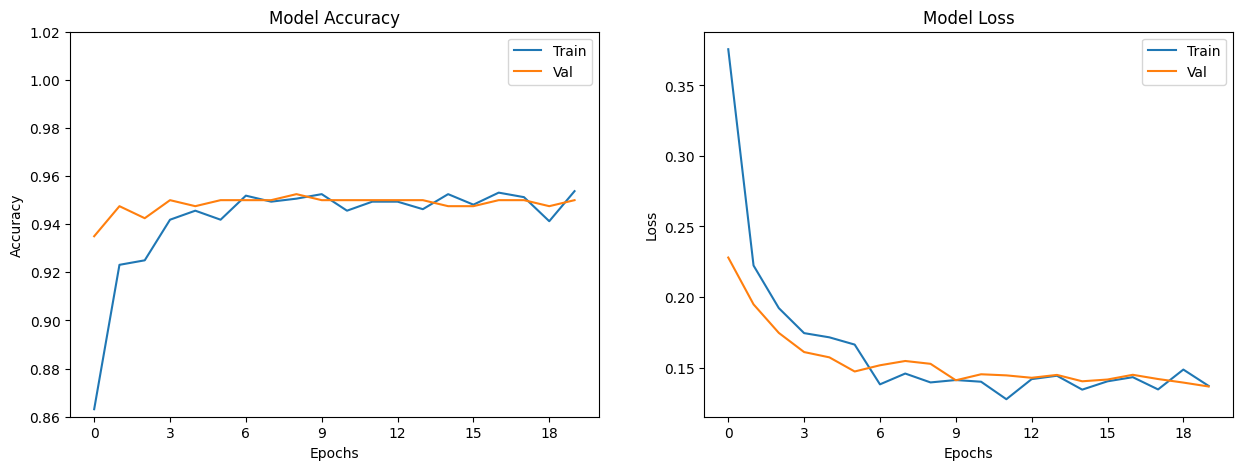

Test Accuracy: 81.75%


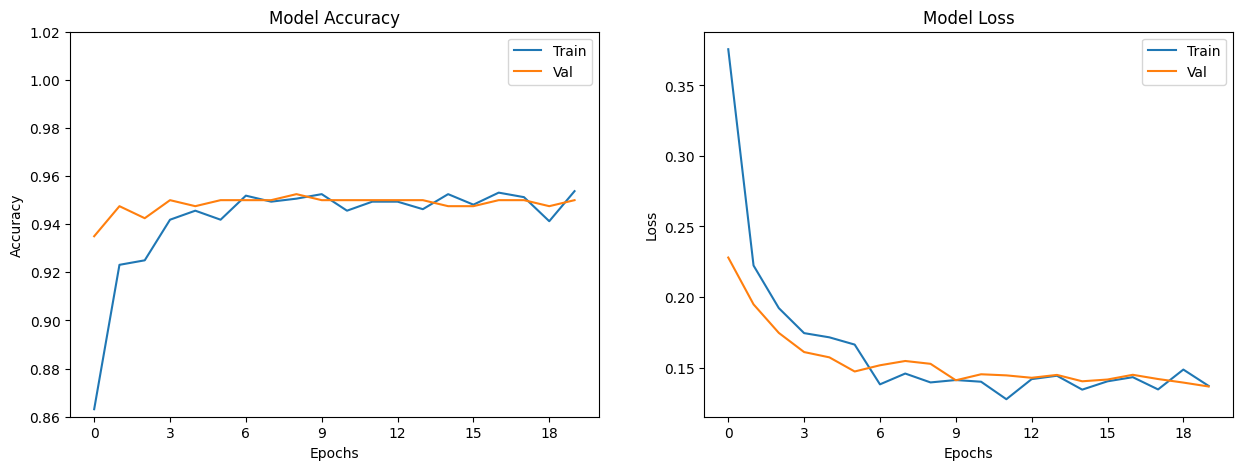

Time Consumption of the Model - EfficientNet-B0 : 27.52 seconds.


In [203]:
model_efficientnet_b0_ffe_003_tuple = get_training_time('EfficientNet-B0', 
                                                                 fixed_feature=True, series_no='003')